<h1>
    <br style ="font-family:UCL-SoM-Outline;color:#EA7600"> GROUP COURSEWORK </br> 
    </p>
</h1>

<div class="image">

<img src="./figures/som_ft.png" width="70%"  align="right">
<h4>
          <p style="font-size:18pt">MSIN0097 Predictive Analytics</p>

</h4>

</div>

<br>
<br>
<br>


# COURSEWORK: WARNER MUSIC



### PREDICTING THE SUCCESS OF ARTISTS ON SPOTIFY

Please complete the sections of this Notebook with supporting code and markup analysis where appropriate. During this coursework you will:

- Understand the specific business forecast task 
- Prepare a dataset, clean and impute where necessary 
- Train an ensemble classifier 
- Evaluate the performance and comment of success and failure modes
- Complete all necessary stages of the data science process 




## 0. Business Case Understanding

### INTRODUCTION

Over the last few years, the music industry has been dominated by digital streaming services, which produce vast amounts of data on listeners and their preferences. 

This has required major players in the industry to adopt a data driven approach to content delivery in order to stay competitive. 

Warner Music Group is looking to leverage its rich database to better understand the factors that have the most significant impact on the success of a new artist. This will allow them to optimize the allocation of resources when signing and promoting new artists.

Warner’s (large) database contains several sources of data, including the streaming platforms Spotify, Amazon Live and Apple Music. 

For this case study, we will be looking using the Spotify dataset to predict the success of artists. In particular, we want to understand the role of Spotify playlists on the performance of artist.

### Streaming Music

When artists release music digitally, details of how their music is streamed can be closely monitored. 

Some of these details include:

- How listeners found their music (a recommendation, a playlist)
- Where and when (a routine visit to the gym, a party, while working). 
- On what device (mobile / PC)
- And so on…

Spotify alone *process nearly 1 billion streams every day* (Dredge, 2015) and this streaming data is documented in detail every time a user accesses the platform. 

Analyzing this data potentially enables us to gain a much deeper insight into customers’ listening behavior and individual tastes. 

Spotify uses it to drive their recommender systems – these tailor and individualize content as well as helping the artists reach wider and more relevant audiences. 

Warner Music would like to use it to better understand the factors that influence the *future success of its artists*, *identify potentially successful acts* early on in their careers and use this analysis to make resource decisions about how they market and support their artists.

### What are Spotify Playlists and why are relevant today?

A playlist is a group of tracks that you can save under a name, listen to, and update at your leisure. 


<img src = 'figures/spotify_playlist_image.png' width="50%"  align="left">

**Figure 1. Screen shot of Spotify product show artists and playlists.**

Spotify currently has more than two billion publicly available playlists, many of which are curated by Spotify’s in-house team of editors. 

The editors scour the web on a daily basis to remain up-to-date with the newest releases, and to create playlists geared towards different desires and needs. 

Additionally, there are playlists such as [Discover Weekly](https://www.spotify.com/uk/discoverweekly/) and [Release Radar](https://support.spotify.com/uk/using_spotify/playlists/release-radar/) that use self-learning algorithms to study a user’s listening behavior over time and recommend songs tailored to his/her tastes.
	
The figure below illustrates the progression of artists on Spotify Playlists:

<img src = 'figures/playlist_heirarchy.png' width="80%"  align="left">

**Figure 2. Figure to illustarte selecting artists and building audience profiles over progressively larger audiences of different playlists. **

The artist pool starts off very dense at the bottom, as new artists are picked up on the smaller playlists, and thins on the way to the top, as only the most promising of them make it through to more selective playlists. The playlists on the very top contain the most successful, chart-topping artists.

An important discovery that has been made is that certain playlists have more of an influence on the popularity, stream count and future success of an artist than others. 

<img src = 'figures/playlist_lift.png' width="80%"  align="left">

** Figure 3. Figure to illustrate taking song stream data and using it to predict the trajectory, and likely success, of Warner artists. **

Moreover, some playlists have been seen to be pivotal in the careers of successful artists. Artists that do make it onto one of these *key* playlists frequently go on to become highly ranked in the music charts. 

It is the objective of Warner’s [A&R](https://en.wikipedia.org/wiki/Artists_and_repertoire) team to identify and sign artists before they achieve this level of success i.e. before they get selected for these playlists, in order to increase their ROI. 

### BUSINESS PROBLEM → DATA PROBLEM

Now that we have a better understanding of the business problem, we can begin to think about how we could model this problem using data. 

The first thing we can do is defining a criterion for measuring artist success. 

Based on our business problem, one way in which we can do this is to create a binary variable representing the success / failure of an artist and determined by whether a song ends up on a key playlist (1), or not (0). We can then generate features for that artist to determine the impact they have on the success of an artist.

Our problem thus becomes a classification task, which can be modeled as follows:

### *Artist Feature 1 + Artist Feature 2 …. + Artist Feature N = Probability of Success*

where,

**Success (1) = Artist Features on Key Playlist**

The key playlists we will use for this case study are the 4 listed below, as recommended by Warner Analysts:

1.	Hot Hits UK
2.	Massive Dance Hits
3.	The Indie List
4.	New Music Friday


The coursework task is to take a look at the Spotify dataset to see how we might be able to set up this classification model.

<br>

## 1. Prepare the problem 

In [182]:
# Preamble 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Import all required libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# To make notebook output stable across runs
np.random.seed(42)

# to plot pretty figures
sns.set_style("darkgrid") 
sns.set(rc={'figure.figsize':(10,5)})

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")



## 2. Data Understanding

<br>
A year’s worth of Spotify streaming data in the WMG database amounts to approximately 50 billion rows of data i.e. 50 billion streams (1.5 to 2 terabytes worth), with a total of seven years of data stored altogether (2010 till today).

For the purposes of this case study, we will be using a sample of this data. The dataset uploaded on the Faculty server is about 16GB, containing data from 2015 - 2017. Given the limits on RAM and cores, we will be taking a further sample of this data for purposes of this case study: a 10% random sample of the total dataset, saved as 'cleaned_data.csv'. 

Read in the data

In [4]:
# Fetching the dataset
spotify = pd.read_csv("cleaned_data.csv", low_memory = False) 

# To display all columns
pd.set_option('display.max_columns', None)

Begin by taking a look at what the Spotify data looks like:

In [5]:
# Preview dataset
spotify.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,day,log_time,mobile,track_id,isrc,upc,artist_name,track_name,album_name,customer_id,postal_code,access,country_code,gender,birth_year,filename,region_code,referral_code,partner_name,financial_product,user_product_type,offline_timestamp,stream_length,stream_cached,stream_source,stream_source_uri,stream_device,stream_os,track_uri,track_artists,source,DateTime,hour,minute,week,month,year,date,weekday,weekday_name,playlist_id,playlist_name
0,0,9,"('small_artists_2016.csv', 9)",10,20160510T12:15:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,Sturgill Simpson,Call To Arms,A Sailor's Guide to Earth,6c022a8376c10aae37abb839eb7625fe,NE,free,GB,male,1968.0,streams_20160510_GB.004.gz,GB-DUR,NaN,NaN,NaN,ad,NaN,277.0,NaN,album,NaN,mobile,Android,spotify:track:4m1opmaYT9zk5OP7IHUb9R,Sturgill Simpson,NaN,2016-05-10 12:15:00,12,15,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN
1,1,19,"('small_artists_2016.csv', 19)",10,20160510T12:15:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,Sturgill Simpson,Call To Arms,A Sailor's Guide to Earth,6c022a8376c10aae37abb839eb7625fe,NE,free,GB,male,1968.0,streams_20160510_GB.004.gz,GB-DUR,NaN,NaN,NaN,ad,NaN,53.0,NaN,album,NaN,mobile,Android,spotify:track:4m1opmaYT9zk5OP7IHUb9R,Sturgill Simpson,NaN,2016-05-10 12:15:00,12,15,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN
2,2,29,"('small_artists_2016.csv', 29)",10,20160510T14:00:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,Sturgill Simpson,Call To Arms,A Sailor's Guide to Earth,352292382ff3ee0cfd3b73b94ea0ff8f,1,premium,GB,male,1995.0,streams_20160510_GB.002.gz,GB-ESS,NaN,NaN,student,paid,NaN,326.0,NaN,collection,NaN,mobile,Android,spotify:track:4m1opmaYT9zk5OP7IHUb9R,Sturgill Simpson,NaN,2016-05-10 14:00:00,14,0,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN
3,3,39,"('small_artists_2016.csv', 39)",10,20160510T10:45:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,Sturgill Simpson,Call To Arms,A Sailor's Guide to Earth,c3f2b54e76696ed491d9d8f964c97774,MK,premium,GB,male,1992.0,streams_20160510_GB.007.gz,GB-HRT,NaN,NaN,student,paid,NaN,330.0,NaN,collection,NaN,tablet,iOS,spotify:track:4m1opmaYT9zk5OP7IHUb9R,Sturgill Simpson,NaN,2016-05-10 10:45:00,10,45,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN
4,4,49,"('small_artists_2016.csv', 49)",10,20160510T10:15:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,Sturgill Simpson,Call To Arms,A Sailor's Guide to Earth,6a06a9bbe042c73e8f1a3596ec321636,KT,premium,GB,male,1979.0,streams_20160510_GB.004.gz,GB-LND,NaN,NaN,NaN,paid,NaN,90.0,NaN,collection,NaN,mobile,iOS,spotify:track:4m1opmaYT9zk5OP7IHUb9R,Sturgill Simpson,NaN,2016-05-10 10:15:00,10,15,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN


Each row in the data is a unique stream – every time a user streams a song in the Warner Music catalogue for at least 30 seconds it becomes a row in the database. Each stream counts as a ‘transaction’, the value of which is £0.0012, and accordingly, 1000 streams of a song count as a ‘sale’ (worth £1) for the artist. The dataset is comprised of listeners in Great Britain only.

Not all the columns provided are relevant to us. Lets take a look at some basic properties of the dataset, and identify the columns that are important for this study


The columns you should *focus* on for this case study are:

* Log Time – timestamp of each stream
* Artist Name(s) – some songs feature more than one artist
* Track Name
* ISRC - (Unique code identifier for that version of the song, i.e. radio edit, album version, remix etc.)
* Customer ID
* Birth Year
* Location of Customer
* Gender of Customer
* Stream Source URI – where on Spotify was the song played – unique playlist ID, an artist’s page, an album etc.


In [6]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805499 entries, 0 to 3805498
Data columns (total 45 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Unnamed: 0.1       int64  
 2   Unnamed: 0.1.1     object 
 3   day                int64  
 4   log_time           object 
 5   mobile             bool   
 6   track_id           object 
 7   isrc               object 
 8   upc                float64
 9   artist_name        object 
 10  track_name         object 
 11  album_name         object 
 12  customer_id        object 
 13  postal_code        object 
 14  access             object 
 15  country_code       object 
 16  gender             object 
 17  birth_year         float64
 18  filename           object 
 19  region_code        object 
 20  referral_code      float64
 21  partner_name       object 
 22  financial_product  object 
 23  user_product_type  object 
 24  offline_timestamp  float64
 25  stream_length     

In [7]:
spotify.count(0)/spotify.shape[0] * 100

Unnamed: 0           100.000000
Unnamed: 0.1         100.000000
Unnamed: 0.1.1       100.000000
day                  100.000000
log_time             100.000000
mobile               100.000000
track_id             100.000000
isrc                  99.999895
upc                  100.000000
artist_name          100.000000
track_name           100.000000
album_name           100.000000
customer_id          100.000000
postal_code           64.467708
access               100.000000
country_code         100.000000
gender                98.937800
birth_year            99.736671
filename             100.000000
region_code           93.116382
referral_code          0.000000
partner_name          11.216742
financial_product     38.796489
user_product_type     99.395822
offline_timestamp      0.000000
stream_length        100.000000
stream_cached          0.000000
stream_source        100.000000
stream_source_uri     27.430595
stream_device        100.000000
stream_os            100.000000
track_ur

### EXPLORATORY ANALYSIS AND PLOTS


Now look at the data set in more detail. 

In [8]:
# summary statistics of the dataset 
summary_stats = {"Total Number of Rows": len(spotify),
                "Total Number of Columns": len(spotify.columns),
                "Total Number of Unique Artists":spotify.artist_name.nunique(),
                "Total Number of Unique Users":spotify.customer_id.nunique(),
                "Total Number of Unique Playlists":spotify.playlist_name.nunique(),
                "Total Number of Unique Regions":spotify.region_code.nunique(),}
summary_stats

{'Total Number of Rows': 3805499,
 'Total Number of Columns': 45,
 'Total Number of Unique Artists': 661,
 'Total Number of Unique Users': 2091144,
 'Total Number of Unique Playlists': 7102,
 'Total Number of Unique Regions': 514}

In [9]:
# datetime
date = pd.to_datetime(spotify['date'], format = '%Y-%m-%d')
date_range = str(date.dt.date.min()) + ' to ' +str(date.dt.date.max())
date_range

'2014-06-10 to 2017-07-10'

In [10]:
# most popular playlists by stream count 
popular_playlists = spotify.groupby(["playlist_name"])["customer_id"].count().reset_index()
popular_playlists = popular_playlists.sort_values(by="customer_id", ascending = False)
popular_playlists.reset_index(drop = True, inplace = True)
popular_playlists.rename(columns={'customer_id': 'Count'}, inplace=True)
popular_playlists = popular_playlists.head(10)
popular_playlists

,playlist_name,Count
0,Hot Hits UK,193654
1,Today's Top Hits,105383
2,Topsify UK Top 40,54982
3,Freshness: Hot House Music,32961
4,The Pop List,28630
5,New Music Monday UK,27793
6,Happy Hits!,18767
7,Summer Hits,16822
8,Top Tracks in The United Kingdom,15524
9,You've Got Male - R&B: The Men,14777


In [11]:
# most popular artists by stream count 
# Creating Dataframe of Top 10 Artists
data = spotify.copy()
top_ten = data[["artist_name", "stream_length"]]
top_ten = top_ten.groupby("artist_name").sum()
top_ten = top_ten.sort_values(by="stream_length", ascending = False)
top_ten = top_ten.reset_index()
top_ten = top_ten.iloc[0:10]
top_ten

,artist_name,stream_length
0,Charlie Puth,83200389.0
1,Lukas Graham,64529983.0
2,Dua Lipa,56221544.0
3,Cheat Codes,47190001.0
4,Anne-Marie,45243135.0
5,Matoma,44838664.0
6,gnash,35278062.0
7,WSTRN,34932583.0
8,Lil Uzi Vert,24300599.0
9,The Hunna,23578647.0


<ipython-input-12-32d6c059436c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


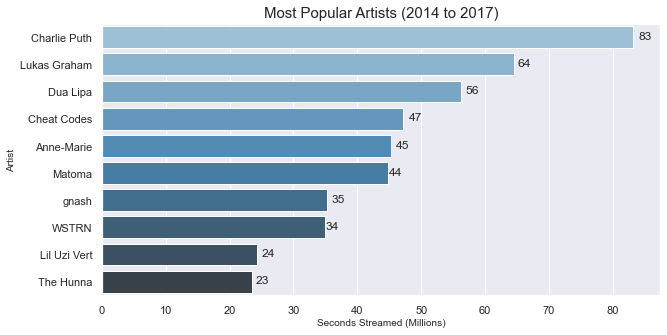

In [12]:
# Setting data for chart
ax = sns.barplot(x="stream_length", y="artist_name", data=top_ten, palette="Blues_d")

# Renaming and setting font size of X, Y Axis Labels and Title
ax.set_xlabel("Seconds Streamed (Millions)",fontsize=10)
ax.set_ylabel("Artist",fontsize=10)
ax.set_title("Most Popular Artists (2014 to 2017)", fontsize=15)

# Renumbering X Axis
xlabels = [int(x) for x in ax.get_xticks()/1000000]
ax.set_xticklabels(xlabels)

# Creating annotations for the chart
annotations = top_ten["stream_length"]/1000000
annotations = annotations.astype(int)

# Adding annotations to the chart
for index, value in enumerate(annotations):
    plt.text((value*1000000)+10**6, index+0.075, str(value), fontsize=12)

plt.savefig('Most Popular Artists 2014 to 2017.png')

In [13]:
# Creating Dataframe of Top 10 Artists by Year
top_five_yearly = data[["artist_name", "stream_length", "year"]]
top_five_yearly = top_five_yearly.groupby(["year", "artist_name"]).sum()
top_five_yearly = top_five_yearly.sort_values(by=["year","stream_length"], ascending = False)
top_five_yearly = top_five_yearly.reset_index(level=["artist_name", "year"])
top_five_yearly = top_five_yearly.groupby("year").head().sort_values(by=["year","stream_length"], ascending = False)

# Dataframe for top 5 artists in 2014, 2015, 2016, 2017
top_five_2014 = top_five_yearly[top_five_yearly["year"]==2014]
top_five_2015 = top_five_yearly[top_five_yearly["year"]==2015]
top_five_2016 = top_five_yearly[top_five_yearly["year"]==2016]
top_five_2017 = top_five_yearly[top_five_yearly["year"]==2017]

<ipython-input-14-7de77de71170>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax14.set_xticklabels(xlabels)


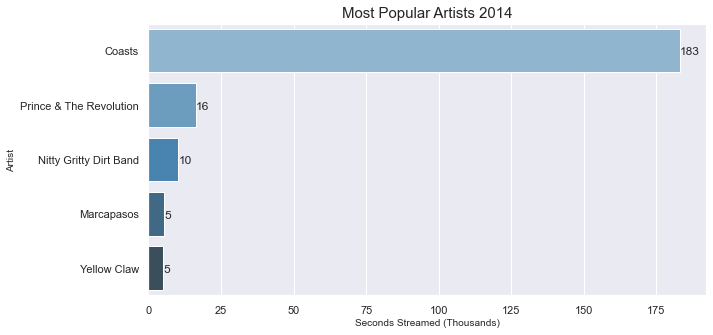

In [14]:
# 2014
# Plotting 2014 data for chart
ax14 = sns.barplot(x="stream_length", y="artist_name", data=top_five_2014, palette="Blues_d")

# Renaming and setting font size of X, Y Axis Labels and Title
ax14.set_xlabel("Seconds Streamed (Thousands)",fontsize=10)
ax14.set_ylabel("Artist",fontsize=10)
ax14.set_title("Most Popular Artists 2014", fontsize=15)

# Renumbering X Axis
xlabels = [int(x) for x in ax14.get_xticks()/1000]
ax14.set_xticklabels(xlabels)

# Creating annotations for the chart
annotations14 = top_five_2014["stream_length"]
annotations14 = annotations14.astype(int)

# Adding annotations to the chart
for index, value in enumerate(annotations14):
    plt.text(value, index+0.075, int(value/1000), fontsize=12)

plt.savefig('Most Popular Artists 2014.png')
plt.show()

<ipython-input-15-b72b7d8fd756>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax15.set_xticklabels(xlabels)


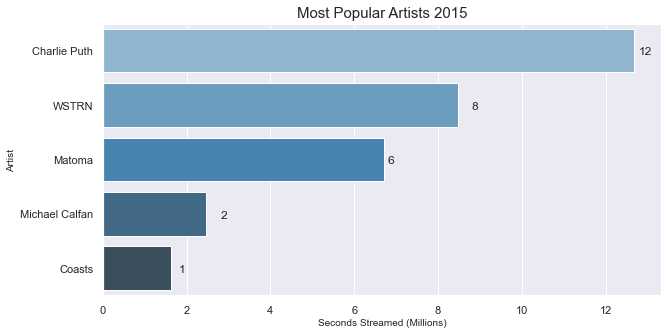

In [15]:
# 2015
# Plotting 2015 data for chart
ax15 = sns.barplot(x="stream_length", y="artist_name", data=top_five_2015, palette="Blues_d")

# Renaming and setting font size of X, Y Axis Labels and Title
ax15.set_xlabel("Seconds Streamed (Millions)",fontsize=10)
ax15.set_ylabel("Artist",fontsize=10)
ax15.set_title("Most Popular Artists 2015", fontsize=15)

# Renumbering X Axis
xlabels = [int(x) for x in ax15.get_xticks()/1000000]
ax15.set_xticklabels(xlabels)

# Creating annotations for the chart
annotations15 = top_five_2015["stream_length"]/1000000
annotations15 = annotations15.astype(int)

# Adding annotations to the chart
for index, value in enumerate(annotations15):
    plt.text((value*1000000)+8*10**5, index+0.075, str(value), fontsize=12)

plt.savefig('Most Popular Artists 2015.png')
plt.show()

<ipython-input-16-8225fd8fbd1d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax16.set_xticklabels(xlabels)


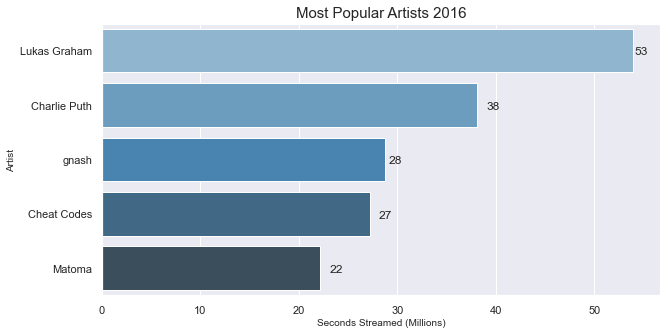

In [16]:
# 2016
# Plotting 2016 data for chart
ax16 = sns.barplot(x="stream_length", y="artist_name", data=top_five_2016, palette="Blues_d")

# Renaming and setting font size of X, Y Axis Labels and Title
ax16.set_xlabel("Seconds Streamed (Millions)",fontsize=10)
ax16.set_ylabel("Artist",fontsize=10)
ax16.set_title("Most Popular Artists 2016", fontsize=15)

# Renumbering X Axis
xlabels = [int(x) for x in ax16.get_xticks()/1000000]
ax16.set_xticklabels(xlabels)

# Creating annotations for the chart
annotations16 = top_five_2016["stream_length"]/1000000
annotations16 = annotations16.astype(int)

# Adding annotations to the chart
for index, value in enumerate(annotations16):
    plt.text((value*1000000)+11*10**5, index+0.075, str(value), fontsize=12)

plt.savefig('Most Popular Artists 2016.png')
plt.show()

<ipython-input-17-932dcd6c6809>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax17.set_xticklabels(xlabels)


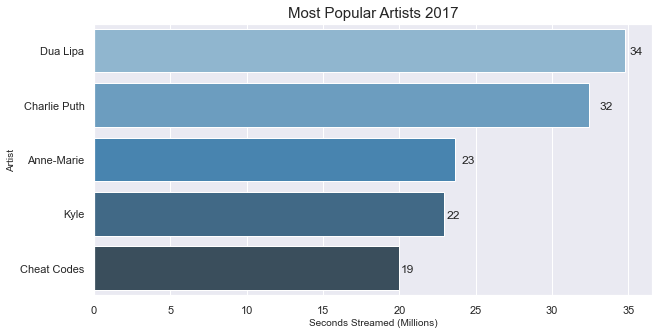

In [17]:
# 2017
# Plotting 2017 data for chart
ax17 = sns.barplot(x="stream_length", y="artist_name", data=top_five_2017, palette="Blues_d")

# Renaming and setting font size of X, Y Axis Labels and Title
ax17.set_xlabel("Seconds Streamed (Millions)",fontsize=10)
ax17.set_ylabel("Artist",fontsize=10)
ax17.set_title("Most Popular Artists 2017", fontsize=15)

# Renumbering X Axis
xlabels = [int(x) for x in ax17.get_xticks()/1000000]
ax17.set_xticklabels(xlabels)

# Creating annotations for the chart
annotations17 = top_five_2017["stream_length"]/1000000
annotations17 = annotations17.astype(int)

# Adding annotations to the chart
for index, value in enumerate(annotations17):
    plt.text((value*1000000)+11*10**5, index+0.075, str(value), fontsize=12)

plt.savefig('Most Popular Artists 2017.png')
plt.show()

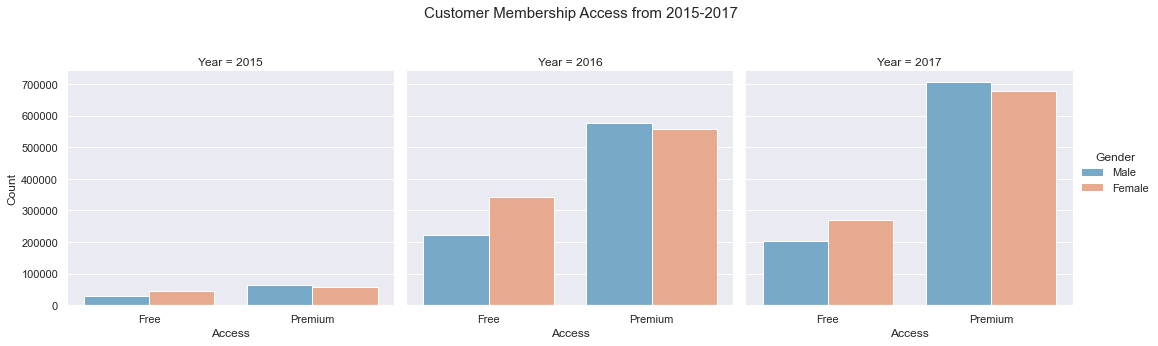

In [18]:
# visualizing customer membership access
access_types = spotify[spotify["access"]!="deleted"]
access_types = access_types[access_types["access"]!="basic-desktop"]

access_types.rename(columns={'year': 'Year'}, inplace=True)

access_from_2014 = access_types[access_types["Year"]>2014]

# set color palette
sns.set_palette(sns.color_palette(["#6AACD6", "#F7A480"]))

# plot customer membership access across gender
g = sns.catplot(x="access", hue="gender", col="Year", data=access_from_2014, kind="count")

plt.ticklabel_format(style='plain', axis='y');

g.despine(left=True)
g.set_xlabels("Access")
g.set_ylabels("Count")
g.set(xticklabels=["Free", "Premium"])

# g.fig.suptitle("Customer Membership Access from 2015-2017", fontsize=10)

g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
g.fig.suptitle("Customer Membership Access from 2015-2017", fontsize=15)

# title
new_title = 'Gender'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Male', 'Female']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('Customer Membership Access from 2015-2017.png')
plt.show();

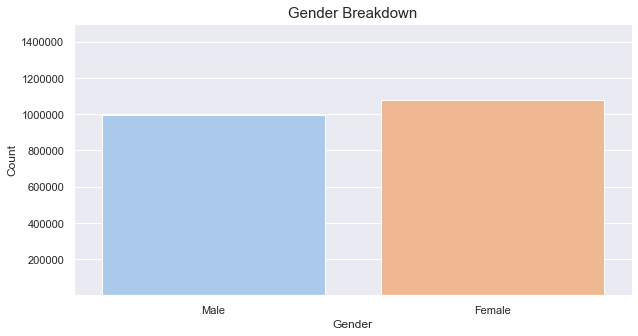

In [19]:
# plot gender 
spot_gender = spotify.copy()
spot_gender["gender"] = spot_gender["gender"].replace(["male"],"Male")
spot_gender["gender"] = spot_gender["gender"].replace(["female"],"Female")
spot_gender = spot_gender.drop_duplicates(["customer_id"])

g1 = sns.countplot(x="gender", data=spot_gender, palette="pastel").set_title("Gender Breakdown", fontsize = 15)

# axes labels
plt.xlabel("Gender") 
plt.ylabel("Count")

plt.ticklabel_format(style='plain', axis='y');
plt.ylim(100, 1500000);
plt.savefig('Gender Breakdown.png')
plt.show();

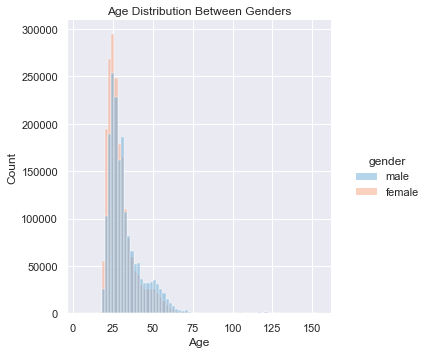

In [20]:
# calculate age 
spotify["age"] = 2021 - spotify["birth_year"]

# set color palette
sns.set_palette(sns.color_palette(["#6AACD6", "#F7A480"]))

# plot gender across age groups
sns.displot(spotify, x="age", hue="gender", stat="count", bins = 75)

# title 
plt.title("Age Distribution Between Genders")

# axes label axes
plt.xlabel("Age")
plt.ylabel("Count")

plt.gcf().subplots_adjust(bottom=0.15)

# y-axis scale
plt.savefig('Age Distribution Between Gender.png')
plt.show()

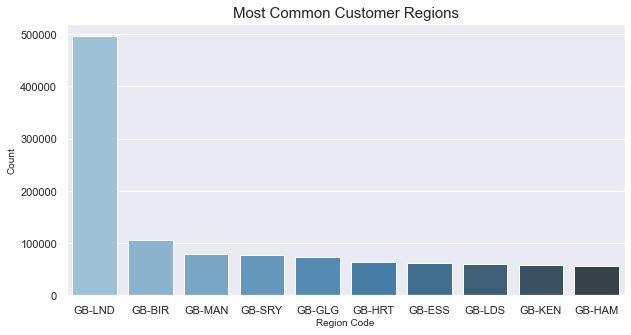

In [21]:
# visualizing customer regions 

common_regions = spotify.groupby(["region_code"])["customer_id"].count().reset_index()

common_regions = common_regions.sort_values(by="customer_id", ascending = False)
common_regions.reset_index(drop = True, inplace = True)
common_regions.rename(columns={'customer_id': 'Count'}, inplace=True)
common_regions = common_regions.head(10)

ax = sns.barplot(x="region_code", y="Count", data=common_regions, palette="Blues_d")
ax.set_title('Most Common Customer Regions', fontsize=15)
plt.xlabel('Region Code', axes=ax, fontsize = 10)
plt.ylabel('Count', axes=ax, fontsize = 10)

plt.savefig('Most Common Customer Regions.png')
plt.show();

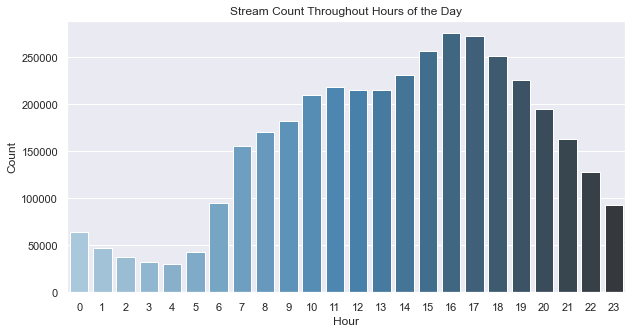

In [22]:
# Plot of Streams vs hour 
sns.countplot(x="hour", data=spotify, palette="Blues_d").set_title("Stream Count Throughout Hours of the Day")
plt.xlabel('Hour')
plt.ylabel('Count')
plt.savefig('Stream count vs Hours of the day.png')
plt.show();

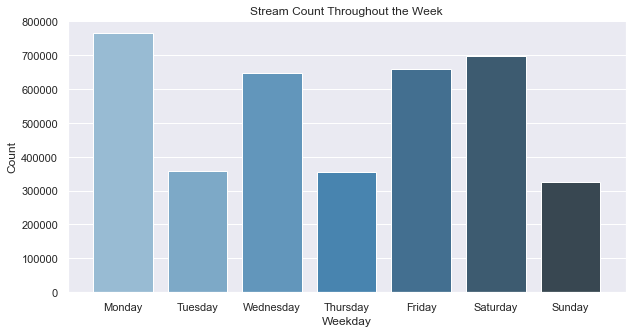

In [23]:
#Plot of Streams vs day 
ax = sns.countplot(x="weekday_name", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                      "Saturday", "Sunday"], data=data, palette="Blues_d").set_title("Stream Count Throughout the Week")
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.savefig('Stream Count Throughout the Week.png')
plt.plot();

## 3.	Data Preperation and Feature Engineering
<br>
From our business understanding, we know that our criteria for success is whether or not an artist has been on one of 4 key playlists.  The column ‘stream_source_uri’, contains data about the source of the stream – whether it was from an artist’s page, an album, a playlist etc. 

For streams coming from different playlists, only the Spotify URI code is provided. To make sense of this column and identify our key playlists, we can use the additional table provided that we cleaned above and named 'playlist_mapper'.

We can being by out data preperation by subsetting the 4 key playlists we are interested in and creating our dependent variable:

**Create Dependent Variable**

In [24]:
# define key playlists indicating success
success_playlists = ['Hot Hits UK', 'Massive Dance Hits', 'The Indie List', 'New Music Friday']

# create appearance column, where 0 = no appearance and 1 = one apperance (in success playlists)
spotify['playlist_appearances'] = np.where(spotify.playlist_name.isin(success_playlists), 1, 0) 

# group artist appearance in playlists
success_artists = pd.DataFrame(spotify.groupby('artist_name').playlist_appearances.sum())

# top 10 artist
success_artists.sort_values(['playlist_appearances'], ascending=False).head(10)

,playlist_appearances
artist_name,
Dua Lipa,37003
Anne-Marie,29165
Charlie Puth,21733
Cheat Codes,17165
Maggie Lindemann,14813
Lukas Graham,14598
WSTRN,13209
Sage The Gemini,11371
Matoma,10793


In [25]:
# Define Dependent Variable
# create binary column where 0 = no success and 1 = success (at least one appearance in success playlists)
success_artists ["success_binary"] = np.where(success_artists['playlist_appearances'] > 0, 1, 0)
success_artists

,playlist_appearances,success_binary
artist_name,,
#90s Update,0,0
17 Memphis,0,0
2D,0,0
3JS,0,0
99 Percent,0,0
...,...,...
birthday,0,0
dvsn,11,1
flor,9,1


In [26]:
# create dependant variable (success_binary) into a dataframe
dependant_variable = pd.DataFrame(success_artists["success_binary"])
dependant_variable

,success_binary
artist_name,
#90s Update,0
17 Memphis,0
2D,0
3JS,0
99 Percent,0
...,...
birthday,0
dvsn,1
flor,1


Now that we have created our dependent variable – whether an artist is successful or not, we can look at generating a set of features, based on the columns within our dataset, that we think might best explain the reasons for this success. 

**FEATURE ENGINEERING**

There are a large number of factors that could have an impact on the success of an artist, such as the influence of a playlist, or the popularity of an artist in a certain geographical region. 

To build a predictive model for this problem, we first need to turn these (largely qualitative) factors into measurable quantities. Characteristics like ‘influence’ and ‘popularity’ need to be quantified and standardized for all artists, to allow for a fair comparison. 

The accurateness of these numerical estimates will be the fundamental driver of success for any model we build. 
There are many approaches one might take to generate features. Based on the data columns available to us, a sensible approach is to divide our feature set into three groups:

1.	Artist Features
2.	Playlist Features
3.	User-base features


## Artist features

*	Stream count
*	Total Number of users
*	Passion Score 

The metric passion score is a metric suggested to us by Warner business analysts. 

It is defined as the number of stream divided by the total number of users. 

Warner analysts believe that repeated listens by a user is a far more indicative future success that simply total number of listens or total unique users. By including this in your model, we can evaluate whether this metric in fact might be of any significance.

In [27]:
# Stream count per artist

# stream count function 
def stream_count(df):
    
    # Creating Copy of dataframe
    new_df = df
    
    # Adding new column with one as the value
    new_df["Stream Count"] = 1
    
    #Grouping new dataframe by artist name
    new_df = new_df.groupby("artist_name").sum()
    new_df.reset_index(inplace = True)
    
    # Selecting Artists and Stream Count for dataframe
    new_df = new_df[["artist_name", "Stream Count"]]
    
    # Setting order of dataframe in alphabetical order
    new_df = new_df.sort_values(by = "artist_name")
    return new_df

In [28]:
# Number of users per artist

# number of users per artist function
def number_of_users(df):
    
    # Creating Copy of dataframe
    new_df = df
    
    # Adding new column with one as the value
    new_df["Number of Users"] = 1
    
    # Dropping duplicates based on artist name and customer id
    new_df = new_df.drop_duplicates(["artist_name", "customer_id"])
    
    # Secting only artist name, customer id and number of users columns
    new_df = new_df[["artist_name", "customer_id", "Number of Users"]]
    
    #Grouping new dataframe by artist name
    new_df = new_df.groupby(["artist_name"]).sum()
    new_df.reset_index(inplace = True)
    
    # Setting order of dataframe in alphabetical order
    new_df = new_df.sort_values(by = "artist_name")
    return new_df

In [29]:
# Passion Score

# Passion Score function
def passion_score(df):
    
    # Applying number of users function to dataframe
    users_df = number_of_users(df)
    
    # Applying number of streams function to dataframe
    streams_df = stream_count(df)
    
    # Concatenating dataframes as they have the same order (alphabetical)
    new_df = pd.concat([streams_df, users_df["Number of Users"]], axis=1)
    
    # Creating Passion Score Column
    new_df["Passion Score"] = new_df["Stream Count"] / new_df["Number of Users"]
    
    # Selecting relevant columns for final dataframe
    new_df = new_df[["artist_name", "Passion Score"]]
    return new_df

In [30]:
artist_streams = stream_count(spotify)
artist_num_users = number_of_users(spotify)
artist_passion = passion_score(spotify)

In [31]:
len(spotify.artist_name.unique()) # 661 unique artists 

661

In [32]:
artist_features = pd.merge(artist_streams, artist_num_users, on = "artist_name")
artist_features = pd.merge(artist_features, artist_passion, on = "artist_name")
artist_features

,artist_name,Stream Count,Number of Users,Passion Score
0,#90s Update,16,15,1.066667
1,17 Memphis,12,12,1.000000
2,2D,1,1,1.000000
3,3JS,5,4,1.250000
4,99 Percent,1291,1189,1.085786
...,...,...,...,...
656,birthday,20,20,1.000000
657,dvsn,25168,18712,1.345019
658,flor,109,108,1.009259
659,gnash,165683,146108,1.133976


## Playlist Features

Understanding an artist’s growth as a function of his/her movement across different playlists is potentially key to understanding how to identify and breakout new artists on Spotify. 

In turn, this could help us identify the most influential playlists and the reasons for their influence.

One way to model the effect of playlists on an artist’s performance has been to include them as categorical features in our model, to note if there are any particular playlists or combinations of playlists that are responsible for propelling an artist to future success:

### *Artist Feature 1 + Artist Feature 2 …. + Artist Feature N = Probability of Success*
**
Success (1) = Artist Features on Key Playlist
Failure (0) = Artist Not Featured on Key Playlist
**

Where,

**
⇒Artist Feature N = Prior Playlist 1 + Prior Playlist 2 +…Prior Playlist N
**


Given that we have over 19,000 playlists in our dataset or 600 artists, using the playlists each artist has featured on, as categorical variables would lead to too many features and a very large, sparse matrix. 

Instead, we need to think of ways to summarize the impact of these playlists. One way to do this would be to consider the top 20 playlists each artist has featured on. 

Even better would be to come up with one metric that captures the net effect of all top 20 prior playlists, for each artist, rather including using all 20 playlists for each artists as binary variables. The intuition here is that if this metric as a whole has an influence on the performance of an artist, it would suggest that rather than the individual playlists themselves, it is a combination of their generalized features that affects the future performance of an artist. 

Accordingly, different combinations of playlists could equate to having the same impact on an artist, thereby allowing us to identify undervalued playlists.

Some of the features such a metric could use is the number of unique users or ‘reach’, number of stream counts, and the passion score of each playlist

* Prior Playlist Stream Counts
* Prior Playlist Unique Users (Reach)
* Prior Playlist Passion Score

There are several other such features that you could generate to better capture the general characteristics of playlists, such as the average lift in stream counts and users they generate for artists that have featured on them. 

The code to calculate these metrics is provided below:

In [33]:
keep_col = ["artist_name", "playlist_name", "customer_id"]
df = spotify[keep_col]
df_notna = df[df['playlist_name'].notna()] # filter to songs in playlists 
df_na = df[df['playlist_name'].isna()] # filter to songs not in playlists

In [34]:
# playlist stream count 

stream1 = df_notna.groupby(["artist_name","playlist_name"])["customer_id"].count().reset_index(name = "count")

# average playlist streams per artist (for artists in playlists)
avg_stream = stream1.groupby(['artist_name']).agg({"count":"mean"}).reset_index()
avg_stream1 = avg_stream.rename(columns={"count": "playlist_avg_stream"})

# average playlist streams per artist -- na values --> 0 (for artists not in playlists)
stream2 = df_na.drop_duplicates(subset=['artist_name'])

stream2 = stream2.drop(["playlist_name","customer_id"], axis = 1)

stream2["playlist_avg_stream"] = 0

avg = pd.concat([avg_stream1, stream2], ignore_index=True)
avg = avg.drop_duplicates(subset=['artist_name'])

In [35]:
# playlist unique users

user2 = df_na.drop_duplicates(subset=['artist_name'])
user2 = user2.drop(["playlist_name","customer_id"], axis = 1)
user2["playlist_avg_user"] = 0
user2 # artists not in playlists 

user1 = df_notna.groupby(["artist_name", "playlist_name"]).customer_id.nunique().reset_index()
user1 # initial count of customers (of artists in playlists)

user1 = user1.rename(columns={"customer_id": "playlist_avg_user"})
user1 = user1.groupby(['artist_name']).agg({"playlist_avg_user":"mean"}).reset_index()

avg_unique_user = pd.concat([user1, user2], ignore_index=True)
avg_unique_user = avg_unique_user.drop_duplicates(subset=['artist_name'])

In [36]:
# playlist passion score and final playlist features df 
unique_user_avg = avg_unique_user
stream_avg = avg

playlist_features = pd.merge(unique_user_avg, stream_avg, on = "artist_name")

playlist_features["passion_score"]= playlist_features["playlist_avg_stream"]/playlist_features["playlist_avg_user"]
playlist_features

,artist_name,playlist_avg_user,playlist_avg_stream,passion_score
0,#90s Update,2.000000,2.000000,1.000000
1,17 Memphis,6.000000,6.000000,1.000000
2,99 Percent,2.666667,2.666667,1.000000
3,A Boogie Wit Da Hoodie,39.090909,41.666667,1.065891
4,A Boogie Wit da Hoodie,15.527778,16.138889,1.039356
...,...,...,...,...
656,Captain Beefheart,0.000000,0.000000,NaN
657,Painters and Dockers,0.000000,0.000000,NaN
658,ALMA,0.000000,0.000000,NaN
659,Angel,0.000000,0.000000,NaN


### Extra Playlist Feature

In [37]:
# Best of the Rest Playlists (Other Top 10)

# Creating List of all the playlists
playlists_list = list(spotify["playlist_name"].drop_duplicates())

# Creating lsit of success playlists
success_playlists = ['Hot Hits UK', 'Massive Dance Hits', 'The Indie List', 'New Music Friday']

# Creating list of playlists that are not defined as success playlists
non_success_playlists = [playlist for playlist in playlists_list if playlist not in success_playlists]

# Checking if 4 big playlists have been dropped from non success playlists
print(len(playlists_list))
print(len(non_success_playlists))

7103
7099


In [38]:
#Making copy of Spotify
sub_spotify = spotify.copy()

# Creating a streams column with values of 1
sub_spotify["streams"] = 1

# Removing rows associated with Success Playlists
sub_spotify = sub_spotify[sub_spotify["playlist_name"].isin(non_success_playlists)]

# Grouping dataframe by Playlist name calculating streams per playlist
sub_spotify = sub_spotify.groupby("playlist_name").agg({"streams":"count"})

# Extracting the (other) top 10 streamed playlists
other_top_10 = sub_spotify.sort_values(by = "streams", ascending = False).iloc[:9]

# Putting Other 10 top 10 playlists in a list
other_top_10 = list(other_top_10.index.values)
other_top_10

["Today's Top Hits",
 'Topsify UK Top 40',
 'Freshness: Hot House Music',
 'The Pop List',
 'New Music Monday UK',
 'Happy Hits!',
 'Summer Hits',
 'Top Tracks in The United Kingdom',
 "You've Got Male - R&B: The Men"]

In [39]:
# create appearance column, where 0 = no appearance and 1 = one apperance (in other top 10)
spotify['top_10_appearances'] = np.where(spotify.playlist_name.isin(other_top_10), 1, 0) 

# group artist appearance in playlists
other_top_10_df = pd.DataFrame(spotify.groupby('artist_name').top_10_appearances.sum())
other_top_10_df

,top_10_appearances
artist_name,
#90s Update,0
17 Memphis,0
2D,0
3JS,0
99 Percent,0
...,...
birthday,0
dvsn,2
flor,0


## User-base features

We can use the age and gender columns to create an audience profile per artist.
*	Gender Percentage Breakdown
*	Age vector quantization 


In [40]:
# Gender breakdown

# Creating dummy variable column for gender (1 if male)
spotify.loc[spotify.gender=="male","gender_num"] = 1 
spotify.loc[spotify.gender=="female","gender_num"] = 0 

# Generating the mean gender numerical values (Percentage of Audience: Male) for each artist
gender_breakdown = spotify.groupby(["artist_name"]).gender_num.mean()
gender_breakdown

# Merging new Percentage of Audience: Male column onto main dataframe and dropping irrelavant column
gender_split = pd.merge(spotify, gender_breakdown, on = "artist_name")
gender_split.drop(["gender_num_x"], axis = 1, inplace = True)

# Renaming Percentage of Audience column: Male
gender_split = gender_split.rename(columns = {"gender_num_y":"male_audience"})
gender_split = gender_split[["artist_name","male_audience"]]
gender_split = gender_split.drop_duplicates(subset = ['artist_name'])
gender_split

,artist_name,male_audience
0,Sturgill Simpson,0.660596
4898,Delafe,0.250000
4930,Willy William,0.526149
6846,Benjamin Beilman,0.635135
6920,Topic,0.563101
...,...,...
3350052,Will Joseph Cook,0.462090
3365374,WSTRN,0.474242
3530259,YONAKA,0.648968
3530599,Zak Abel,0.469928


In [41]:
# Age breakdown

#Create age attribute (However this would be made above !!)
spotify['birth_year'] = 2021 - spotify['birth_year']
spotify.rename(columns = {'birth_year':'Age'}, inplace = True)

In [42]:
# check null values
spotify['Age'].isna().sum()
#Fill missing values with mean age
spotify['Age'].fillna(spotify['Age'].mean())

0          53.0
1          53.0
2          26.0
3          29.0
4          42.0
           ... 
3805494    31.0
3805495    40.0
3805496    22.0
3805497    34.0
3805498    29.0
Name: Age, Length: 3805499, dtype: float64

In [43]:
# Age breakdown/ Age vector quantisation
spotify['Age_profile'] = None
age_profile_artist = spotify[["artist_name", "customer_id", "Age"]]
age_profile_artist = age_profile_artist.drop_duplicates(subset = ['customer_id','artist_name'])

#Define thresold for each age category
age_group_values=[0,18,30,45,100]
age_groups = ['Minor', 'YoungAdult', 'Adult', 'Senior']

#Categorise each age into the age group 

categories = pd.cut(x=age_profile_artist['Age'], bins=age_group_values, labels=age_groups)
age_profile_artist["Age profile"]= categories
age_profile_artist = age_profile_artist.set_index('artist_name')

#reshape
age_profile_artist['Customer count']= age_profile_artist.groupby(['artist_name','Age profile']).customer_id.transform('count')
age_profile_artist = age_profile_artist.reset_index()
age_profile_artist = age_profile_artist.drop_duplicates(subset = ['Age profile','artist_name'])
age_profile_artist = age_profile_artist[["artist_name", "Age profile", "Customer count"]]
age_profile_artist

,artist_name,Age profile,Customer count
0,Sturgill Simpson,Senior,1135.0
1,Sturgill Simpson,YoungAdult,999.0
3,Sturgill Simpson,Adult,2003.0
36,Delafe,YoungAdult,7.0
37,Willy William,YoungAdult,980.0
...,...,...,...
2951018,Anne-Marie,NaN,NaN
2951019,Anne-Marie,Adult,60519.0
2951021,Anne-Marie,YoungAdult,133721.0
2951034,Anne-Marie,Senior,22992.0


In [44]:
age_profile_artist_sum = age_profile_artist.pivot(index='artist_name', columns='Age profile', values='Customer count')
age_profile_artist_sum = age_profile_artist_sum.fillna(0)
age_profile_artist_sum = age_profile_artist_sum[['Minor', 'YoungAdult', 'Adult', 'Senior']]
age_profile_artist_sum

Age profile,Minor,YoungAdult,Adult,Senior
artist_name,,,,
#90s Update,0.0,5.0,9.0,1.0
17 Memphis,0.0,9.0,2.0,1.0
2D,1.0,0.0,0.0,0.0
3JS,0.0,1.0,1.0,2.0
99 Percent,16.0,846.0,188.0,129.0
...,...,...,...,...
birthday,1.0,13.0,6.0,0.0
dvsn,25.0,12145.0,5304.0,1137.0
flor,0.0,58.0,40.0,10.0


In [45]:
# Merging individual dataframes
final_df = pd.merge(artist_features, playlist_features, on = "artist_name")
final_df = pd.merge(final_df, age_profile_artist_sum, on = "artist_name")
final_df = pd.merge(final_df, gender_split, on = "artist_name")
final_df = pd.merge(final_df, other_top_10_df, on = "artist_name")
final_df = pd.merge(final_df, dependant_variable, on = "artist_name")
#final_df = pd.merge(final_df, positivity_score, on = "artist_name")

In [46]:
# Renaming columns for consistency in formatting
final_df = final_df.rename(columns={"Stream Count": "artist_stream_count", "Number of Users": "artist_num_users",
                                   "Passion Score": "artist_passion_score", "passion_score": "playlist_passion_score"})

In [47]:
# Reviewing final dataframe
final_df

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances,success_binary
0,#90s Update,16,15,1.066667,2.000000,2.000000,1.000000,0.0,5.0,9.0,1.0,0.562500,0,0
1,17 Memphis,12,12,1.000000,6.000000,6.000000,1.000000,0.0,9.0,2.0,1.0,0.333333,0,0
2,2D,1,1,1.000000,0.000000,0.000000,NaN,1.0,0.0,0.0,0.0,1.000000,0,0
3,3JS,5,4,1.250000,0.000000,0.000000,NaN,0.0,1.0,1.0,2.0,0.800000,0,0
4,99 Percent,1291,1189,1.085786,2.666667,2.666667,1.000000,16.0,846.0,188.0,129.0,0.322074,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,birthday,20,20,1.000000,1.000000,1.000000,1.000000,1.0,13.0,6.0,0.0,0.400000,0,0
657,dvsn,25168,18712,1.345019,24.836879,26.092199,1.050543,25.0,12145.0,5304.0,1137.0,0.459634,2,1
658,flor,109,108,1.009259,3.083333,3.083333,1.000000,0.0,58.0,40.0,10.0,0.532110,0,1
659,gnash,165683,146108,1.133976,57.217096,59.808684,1.045294,1008.0,90173.0,39105.0,15157.0,0.406923,14788,1


**Principle Component Analysis**

The data also contains a partial region code of the listener. We might want to consider including the regional breakdown of streams per artist as a feature of our model, to know if streams for certain regions are particularly influential on the future performance of an artist. 

However, we have over 400 unique regions and like playlists, including them all would lead to too many features and a large sparse matrix. One way in which to extract relevant ‘generalized’ features of each region would be to incorporate census and demographic data, from publicly available datasets. 

This is however beyond the scope of this courswork. Instead, a better way to summarize the impact of regional variation in streams is to use dimensionality reduction techniques. Here we will use Principle Component Analysis (PCA) to capture the regional variation in stream count.

PCA captures the majority of variation in the original feature set and represents it as a set of new orthogonal variables. Each ‘component’ of PCA is a linear combination of every feature, i.e. playlist in the dataset. Use **`scikit-learn`**’s PCA module (Pedregosa, et al., 2011) for generating PCA components.

For a comprehensive understanding of how sklearn's PCA module works, please refer to the sklearn documentation. We will using 10 components of PCA in our model.

*Note: We could also apply a similar method to condense variation in stream across the 19,600 different playlists in our dataset.*

In [48]:
# Taking Relevant Columns to create Regions Dataset
regions = spotify.copy()
regions["streams"] = 1
regions = regions[["artist_name","region_code","streams"]]
regions

,artist_name,region_code,streams
0,Sturgill Simpson,GB-DUR,1
1,Sturgill Simpson,GB-DUR,1
2,Sturgill Simpson,GB-ESS,1
3,Sturgill Simpson,GB-HRT,1
4,Sturgill Simpson,GB-LND,1
...,...,...,...
3805494,Anne-Marie,GB-ESX,1
3805495,Anne-Marie,GB-STE,1
3805496,Anne-Marie,GB-BNE,1
3805497,Anne-Marie,GB-RDG,1


In [49]:
# Finding the most common region for filling NA values (GB-LND)
most_common = regions.groupby(["region_code"])["streams"].count().reset_index()
most_common = most_common.sort_values(by="streams", ascending = False)
most_common.reset_index(drop = True, inplace = True)
common_region = most_common.iloc[0, 0]
common_region

'GB-LND'

In [50]:
# Filling NAs with the most common region and grouping regions table
regions["region_code"].fillna(value = common_region, inplace = True)
regions = regions.groupby(by = ["artist_name", "region_code"]).sum()
regions.reset_index(inplace = True)
regions.head()

,artist_name,region_code,streams
0,#90s Update,GB-BRY,1
1,#90s Update,GB-COV,1
2,#90s Update,GB-GLG,1
3,#90s Update,GB-HAV,2
4,#90s Update,GB-HLD,1


In [51]:
# Unpivotting region_code colum for structure needed to conduct PCA
regions = regions.pivot(index = "artist_name", columns = "region_code", values = "streams")
regions = regions.fillna(0)
regions = regions.astype(int)
regions

region_code,0,500,501,502,504,505,506,508,510,511,512,513,514,517,518,519,521,524,526,527,528,531,532,533,534,535,536,538,539,542,543,544,546,547,548,551,555,556,557,560,563,564,566,567,570,571,575,576,581,582,584,588,592,598,602,604,605,609,610,613,616,617,618,622,623,625,627,630,634,635,637,640,641,647,648,649,650,659,669,671,678,679,686,702,709,710,711,722,743,744,751,752,753,754,756,762,765,770,771,789,790,801,802,803,807,811,819,820,825,828,839,855,862,866,868,AR-B,AR-C,AR-E,AR-T,AR-W,AR-X,AR-Z,AU-ACT,AU-NSW,AU-NT,AU-QLD,AU-SA,AU-TAS,AU-VIC,AU-WA,BE-BRU,BE-VAN,BE-VBR,BE-VLI,BE-VOV,BE-VWV,BE-WBR,BE-WHT,BE-WLG,BR-BA,BR-DF,BR-ES,BR-GO,BR-MG,BR-PB,BR-PR,BR-RJ,BR-RN,BR-RS,BR-SC,BR-SP,BR-TO,DE-BB,DE-BE,DE-BW,DE-BY,DE-HB,DE-HE,DE-HH,DE-NI,DE-NW,DE-RP,DE-SH,DE-SN,DE-ST,DE-TH,DK-81,DK-82,DK-83,DK-84,DK-85,ES-AN,ES-AR,ES-AS,ES-CB,ES-CL,ES-CM,ES-CN,ES-CT,ES-EX,ES-GA,ES-IB,ES-MC,ES-MD,ES-NC,ES-PV,ES-RI,ES-VC,FI-ES,FI-IS,FI-LL,FI-LS,FI-OL,FR-A,FR-B,FR-C,FR-D,FR-E,FR-F,FR-I,FR-J,FR-K,FR-L,FR-M,FR-N,FR-O,FR-P,FR-Q,FR-R,FR-S,FR-T,FR-U,FR-V,GB-ABD,GB-ABE,GB-AGB,GB-AGY,GB-ANS,GB-ANT,GB-ARD,GB-ARM,GB-BAS,GB-BBD,GB-BDG,GB-BEN,GB-BEX,GB-BFS,GB-BGE,GB-BGW,GB-BIR,GB-BKM,GB-BLA,GB-BLY,GB-BMH,GB-BNB,GB-BNE,GB-BNH,GB-BNS,GB-BOL,GB-BPL,GB-BRC,GB-BRD,GB-BRY,GB-BST,GB-BUR,GB-CAM,GB-CAY,GB-CBF,GB-CGN,GB-CGV,GB-CHE,GB-CKF,GB-CKT,GB-CLD,GB-CLK,GB-CLR,GB-CMA,GB-CMD,GB-CMN,GB-CON,GB-COV,GB-CRF,GB-CRY,GB-CSR,GB-CWY,GB-DAL,GB-DBY,GB-DEN,GB-DER,GB-DEV,GB-DGN,GB-DGY,GB-DNC,GB-DND,GB-DOR,GB-DOW,GB-DRY,GB-DUD,GB-DUR,GB-EAL,GB-EAY,GB-EDH,GB-EDU,GB-ELN,GB-ELS,GB-ENF,GB-ERW,GB-ERY,GB-ESS,GB-ESX,GB-FAL,GB-FER,GB-FIF,GB-FLN,GB-GAT,GB-GLG,GB-GLS,GB-GRE,GB-GWN,GB-HAL,GB-HAM,GB-HAV,GB-HCK,GB-HEF,GB-HIL,GB-HLD,GB-HMF,GB-HNS,GB-HPL,GB-HRT,GB-HRW,GB-HRY,GB-IOW,GB-ISL,GB-IVC,GB-KEC,GB-KEN,GB-KHL,GB-KIR,GB-KTT,GB-KWL,GB-LAN,GB-LBH,GB-LCE,GB-LDS,GB-LEC,GB-LEW,GB-LIN,GB-LIV,GB-LMV,GB-LND,GB-LRN,GB-LSB,GB-LUT,GB-MAN,GB-MDB,GB-MDW,GB-MFT,GB-MIK,GB-MLN,GB-MON,GB-MRT,GB-MRY,GB-MTY,GB-MYL,GB-NAY,GB-NBL,GB-NDN,GB-NEL,GB-NET,GB-NFK,GB-NGM,GB-NLK,GB-NLN,GB-NSM,GB-NTA,GB-NTH,GB-NTL,GB-NTT,GB-NTY,GB-NWM,GB-NWP,GB-NYK,GB-NYM,GB-OLD,GB-OMH,GB-ORK,GB-OXF,GB-PEM,GB-PKN,GB-PLY,GB-POL,GB-POR,GB-POW,GB-PTE,GB-RCC,GB-RCH,GB-RCT,GB-RDB,GB-RDG,GB-RFW,GB-RIC,GB-ROT,GB-RUT,GB-SAW,GB-SAY,GB-SCB,GB-SFK,GB-SFT,GB-SGC,GB-SHF,GB-SHN,GB-SHR,GB-SKP,GB-SLF,GB-SLG,GB-SLK,GB-SND,GB-SOL,GB-SOM,GB-SOS,GB-SRY,GB-STB,GB-STE,GB-STG,GB-STH,GB-STN,GB-STS,GB-STT,GB-STY,GB-SWA,GB-SWD,GB-SWK,GB-TAM,GB-TFW,GB-THR,GB-TOB,GB-TOF,GB-TRF,GB-TWH,GB-VGL,GB-WAR,GB-WBK,GB-WDU,GB-WFT,GB-WGN,GB-WIL,GB-WKF,GB-WLL,GB-WLN,GB-WLV,GB-WND,GB-WNM,GB-WOK,GB-WOR,GB-WRL,GB-WRT,GB-WRX,GB-WSM,GB-WSX,GB-YOR,GB-ZET,IT-21,IT-25,IT-32,IT-34,IT-36,IT-42,IT-45,IT-52,IT-55,IT-57,IT-62,IT-65,IT-72,IT-75,IT-78,IT-82,IT-88,MX-COA,MX-DIF,MX-MEX,MX-MOR,MX-NAY,MX-NLE,MX-PUE,MX-QUE,MX-ROO,MX-SLP,MX-SON,MX-VER,MX-YUC,MX-ZAC,NL-FL,NL-GE,NL-GR,NL-LI,NL-NB,NL-NH,NL-OV,NL-UT,NL-ZE,NL-ZH,NO-01,NO-02,NO-03,NO-04,NO-06,NO-07,NO-08,NO-09,NO-11,NO-12,NO-14,NO-15,NO-16,NO-17,NO-18,SE-AB,SE-AC,SE-BD,SE-C,SE-E,SE-F,SE-G,SE-H,SE-M,SE-N,SE-O,SE-S,SE-T,SE-W,SE-Y,SE-Z
artist_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#90s Update,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [52]:
# Merging final dataset and region dataset
final_incl_regions_df = pd.merge(final_df, regions, on = "artist_name")
final_incl_regions_df

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances,success_binary,0,500,501,502,504,505,506,508,510,511,512,513,514,517,518,519,521,524,526,527,528,531,532,533,534,535,536,538,539,542,543,544,546,547,548,551,555,556,557,560,563,564,566,567,570,571,575,576,581,582,584,588,592,598,602,604,605,609,610,613,616,617,618,622,623,625,627,630,634,635,637,640,641,647,648,649,650,659,669,671,678,679,686,702,709,710,711,722,743,744,751,752,753,754,756,762,765,770,771,789,790,801,802,803,807,811,819,820,825,828,839,855,862,866,868,AR-B,AR-C,AR-E,AR-T,AR-W,AR-X,AR-Z,AU-ACT,AU-NSW,AU-NT,AU-QLD,AU-SA,AU-TAS,AU-VIC,AU-WA,BE-BRU,BE-VAN,BE-VBR,BE-VLI,BE-VOV,BE-VWV,BE-WBR,BE-WHT,BE-WLG,BR-BA,BR-DF,BR-ES,BR-GO,BR-MG,BR-PB,BR-PR,BR-RJ,BR-RN,BR-RS,BR-SC,BR-SP,BR-TO,DE-BB,DE-BE,DE-BW,DE-BY,DE-HB,DE-HE,DE-HH,DE-NI,DE-NW,DE-RP,DE-SH,DE-SN,DE-ST,DE-TH,DK-81,DK-82,DK-83,DK-84,DK-85,ES-AN,ES-AR,ES-AS,ES-CB,ES-CL,ES-CM,ES-CN,ES-CT,ES-EX,ES-GA,ES-IB,ES-MC,ES-MD,ES-NC,ES-PV,ES-RI,ES-VC,FI-ES,FI-IS,FI-LL,FI-LS,FI-OL,FR-A,FR-B,FR-C,FR-D,FR-E,FR-F,FR-I,FR-J,FR-K,FR-L,FR-M,FR-N,FR-O,FR-P,FR-Q,FR-R,FR-S,FR-T,FR-U,FR-V,GB-ABD,GB-ABE,GB-AGB,GB-AGY,GB-ANS,GB-ANT,GB-ARD,GB-ARM,GB-BAS,GB-BBD,GB-BDG,GB-BEN,GB-BEX,GB-BFS,GB-BGE,GB-BGW,GB-BIR,GB-BKM,GB-BLA,GB-BLY,GB-BMH,GB-BNB,GB-BNE,GB-BNH,GB-BNS,GB-BOL,GB-BPL,GB-BRC,GB-BRD,GB-BRY,GB-BST,GB-BUR,GB-CAM,GB-CAY,GB-CBF,GB-CGN,GB-CGV,GB-CHE,GB-CKF,GB-CKT,GB-CLD,GB-CLK,GB-CLR,GB-CMA,GB-CMD,GB-CMN,GB-CON,GB-COV,GB-CRF,GB-CRY,GB-CSR,GB-CWY,GB-DAL,GB-DBY,GB-DEN,GB-DER,GB-DEV,GB-DGN,GB-DGY,GB-DNC,GB-DND,GB-DOR,GB-DOW,GB-DRY,GB-DUD,GB-DUR,GB-EAL,GB-EAY,GB-EDH,GB-EDU,GB-ELN,GB-ELS,GB-ENF,GB-ERW,GB-ERY,GB-ESS,GB-ESX,GB-FAL,GB-FER,GB-FIF,GB-FLN,GB-GAT,GB-GLG,GB-GLS,GB-GRE,GB-GWN,GB-HAL,GB-HAM,GB-HAV,GB-HCK,GB-HEF,GB-HIL,GB-HLD,GB-HMF,GB-HNS,GB-HPL,GB-HRT,GB-HRW,GB-HRY,GB-IOW,GB-ISL,GB-IVC,GB-KEC,GB-KEN,GB-KHL,GB-KIR,GB-KTT,GB-KWL,GB-LAN,GB-LBH,GB-LCE,GB-LDS,GB-LEC,GB-LEW,GB-LIN,GB-LIV,GB-LMV,GB-LND,GB-LRN,GB-LSB,GB-LUT,GB-MAN,GB-MDB,GB-MDW,GB-MFT,GB-MIK,GB-MLN,GB-MON,GB-MRT,GB-MRY,GB-MTY,GB-MYL,GB-NAY,GB-NBL,GB-NDN,GB-NEL,GB-NET,GB-NFK,GB-NGM,GB-NLK,GB-NLN,GB-NSM,GB-NTA,GB-NTH,GB-NTL,GB-NTT,GB-NTY,GB-NWM,GB-NWP,GB-NYK,GB-NYM,GB-OLD,GB-OMH,GB-ORK,GB-OXF,GB-PEM,GB-PKN,GB-PLY,GB-POL,GB-POR,GB-POW,GB-PTE,GB-RCC,GB-RCH,GB-RCT,GB-RDB,GB-RDG,GB-RFW,GB-RIC,GB-ROT,GB-RUT,GB-SAW,GB-SAY,GB-SCB,GB-SFK,GB-SFT,GB-SGC,GB-SHF,GB-SHN,GB-SHR,GB-SKP,GB-SLF,GB-SLG,GB-SLK,GB-SND,GB-SOL,GB-SOM,GB-SOS,GB-SRY,GB-STB,GB-STE,GB-STG,GB-STH,GB-STN,GB-STS,GB-STT,GB-STY,GB-SWA,GB-SWD,GB-SWK,GB-TAM,GB-TFW,GB-THR,GB-TOB,GB-TOF,GB-TRF,GB-TWH,GB-VGL,GB-WAR,GB-WBK,GB-WDU,GB-WFT,GB-WGN,GB-WIL,GB-WKF,GB-WLL,GB-WLN,GB-WLV,GB-WND,GB-WNM,GB-WOK,GB-WOR,GB-WRL,GB-WRT,GB-WRX,GB-WSM,GB-WSX,GB-YOR,GB-ZET,IT-21,IT-25,IT-32,IT-34,IT-36,IT-42,IT-45,IT-52,IT-55,IT-57,IT-62,IT-65,IT-72,IT-75,IT-78,IT-82,IT-88,MX-COA,MX-DIF,MX-MEX,MX-MOR,MX-NAY,MX-NLE,MX-PUE,MX-QUE,MX-ROO,MX-SLP,MX-SON,MX-VER,MX-YUC,MX-ZAC,NL-FL,NL-GE,NL-GR,NL-LI,NL-NB,NL-NH,NL-OV,NL-UT,NL-ZE,NL-ZH,NO-01,NO-02,NO-03,NO-04,NO-06,NO-07,NO-08,NO-09,NO-11,NO-12,NO-14,NO-15,NO-16,NO-17,NO-18,SE-AB,SE-AC,SE-BD,SE-C,SE-E,SE-F,SE-G,SE-H,SE-M,SE-N,SE-O,SE-S,SE-T,SE-W,SE-Y,SE-Z
0,#90s Update,16,15,1.066667,2.000000,2.000000,1.000000,0.0,5.0,9.0,1.0,0.562500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [53]:
# Dividing the final regions into predictor and labels
X = final_incl_regions_df.drop(['success_binary'], axis=1)
y = final_incl_regions_df['success_binary']

In [54]:
from sklearn.model_selection import train_test_split

# Splitting the dataframe into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify =y)

In [55]:
# Assessing shape of train predictors
X_train.shape

(462, 527)

In [56]:
# Assessing shape of test predictors
X_test.shape

(199, 527)

In [57]:
# Splitting regions from other variable columns in Train Set
X_train_regions = X_train.iloc[:, 13:]
X_train_no_regions = X_train.iloc[:, :13]
X_train_no_regions

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances
133,Daniella Mason,115,110,1.045455,1.000000,1.000000,1.000000,0.0,73.0,33.0,4.0,0.394737,0
126,Crying Day Care Choir,25,25,1.000000,3.750000,3.750000,1.000000,0.0,10.0,11.0,4.0,0.440000,0
639,YFN Lucci,1487,1395,1.065950,12.960000,13.120000,1.012346,18.0,998.0,299.0,74.0,0.777328,0
490,SWEAT,2265,1998,1.133634,81.500000,90.900000,1.115337,0.0,741.0,921.0,321.0,0.603224,0
206,HEDIA,5119,4932,1.037916,137.807692,139.884615,1.015071,13.0,2600.0,1727.0,568.0,0.577157,898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,RIVRS,1424,1331,1.069872,11.650000,11.750000,1.008584,4.0,766.0,435.0,120.0,0.428368,61
76,Bl!ndman,2,2,1.000000,0.000000,0.000000,NaN,0.0,0.0,2.0,0.0,0.500000,0
362,Maria Peszek,40,38,1.052632,2.000000,2.000000,1.000000,0.0,9.0,25.0,4.0,0.475000,0
365,Marie Bothmer,6,6,1.000000,2.000000,2.000000,1.000000,0.0,6.0,0.0,0.0,0.333333,0


In [58]:
# Splitting regions from other variable columns in Test Set
X_test_regions = X_test.iloc[:, 13:]
X_test_no_regions = X_test.iloc[:, :13]

In [59]:
# Region Code PCA

# Importing Relevant Packages
from sklearn.decomposition import PCA

# Indicating the initial desired level of variance to be kept
pca = PCA(0.99)

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_regions = scaler.fit_transform(X_train_regions)

In [61]:
# Fitting PCA to X Train Regions
pca.fit(X_train_regions)

PCA(n_components=0.99)

In [62]:
# Number of Principal Compontents
pca.n_components_

63

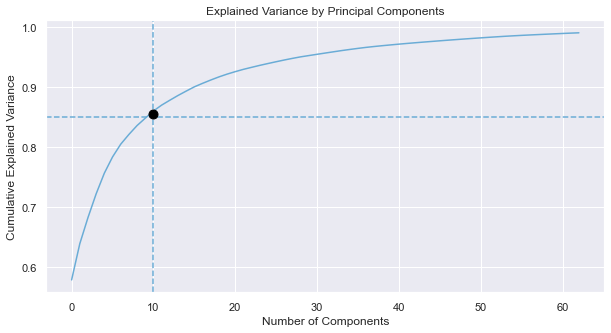

In [63]:
# PCA Visualisation Assessing the Variance Explained by Components

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.axhline(y=0.85, xmin=0, xmax=63,  linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, linestyle='--')

plt.plot(9.9, 0.855, marker='o', markersize=9, color="black")

plt.show()

In [64]:
# Setting new level of variance based on the graphs elbow point
pca = PCA(n_components = 10)

# Fitting PCA to X Train Regions
pca.fit(X_train_regions)

# Number of Principal Components
pca.n_components_

10

In [65]:
# Explained Variance for each of the 10 Components
pca.explained_variance_ratio_

array([0.57804112, 0.06032819, 0.04362859, 0.03962056, 0.03446092,
       0.02699665, 0.02129331, 0.01625789, 0.01487334, 0.01225947])

In [66]:
# Transforming the X_train regions through PCA
X_train_pca = pca.transform(X_train_regions)

In [67]:
# Transforming the X_test regions through PCA
X_test_pca = pca.transform(X_test_regions)

In [68]:
# Explaining the effect of PCA on the training regions data
old_dimensions = str(X_train_regions.shape[1])
new_dimensions = str(X_train_pca.shape[1])
variance_explained = str(round(sum(pca.explained_variance_ratio_), 3)*100)

print("PCA reduced the regions dataframe dimensions from " + old_dimensions + " to " + new_dimensions + ". These new PCA compenents explain " + variance_explained + "% of the variance within the prior variables.")

PCA reduced the regions dataframe dimensions from 514 to 10. These new PCA compenents explain 84.8% of the variance within the prior variables.


Check the PCA feature table to make sure the dataframe looks as expected. Comment on anything the looks important. 

In [69]:
# Converting PCA component array into a Dataframe for merging
pca_columns = ["pca_component_1", "pca_component_2", "pca_component_3", "pca_component_4", "pca_component_5", "pca_component_6", "pca_component_7", "pca_component_8", "pca_component_9", "pca_component_10"]
X_train_pca = pd.DataFrame(data = X_train_pca, columns = pca_columns)
X_train_pca

,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10
0,-2.992491,0.145448,-0.102796,-0.075100,-0.261500,-0.090708,-0.078492,-0.071781,-0.305747,-0.085636
1,-3.004898,0.144743,-0.105028,-0.075653,-0.265168,-0.086917,-0.076404,-0.072939,-0.304837,-0.091842
2,-2.369132,0.135369,0.036813,0.101779,-0.037701,-0.008093,-0.128936,-0.200332,-0.108339,-0.193684
3,-2.263916,0.416266,-0.195282,-0.216819,0.061541,0.061272,-0.041368,0.163179,-0.228759,0.068050
4,0.721657,-1.210932,-0.800722,1.889089,-1.241450,1.059177,3.138207,-0.412715,1.491993,3.392102
...,...,...,...,...,...,...,...,...,...,...
457,-2.359498,0.047680,-0.177895,-0.185154,0.150280,0.617241,-0.002922,0.159434,-0.526652,-0.324826
458,-3.019408,0.147580,-0.101181,-0.072484,-0.267208,-0.084740,-0.076726,-0.073369,-0.303837,-0.090968
459,-3.012279,0.146968,-0.101727,-0.074116,-0.266001,-0.085973,-0.077290,-0.072916,-0.304286,-0.090295
460,-3.018585,0.147597,-0.101214,-0.072495,-0.266845,-0.085036,-0.076948,-0.073232,-0.303913,-0.090538


In [70]:
# Merging PCA components to the remaining x train data
# By setting the PCA components indexes to the remaining x train data's indexes
X_train_merged = pd.concat([X_train_no_regions, X_train_pca.set_index(X_train_no_regions.index)], axis=1)
X_train_merged

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10
133,Daniella Mason,115,110,1.045455,1.000000,1.000000,1.000000,0.0,73.0,33.0,4.0,0.394737,0,-2.992491,0.145448,-0.102796,-0.075100,-0.261500,-0.090708,-0.078492,-0.071781,-0.305747,-0.085636
126,Crying Day Care Choir,25,25,1.000000,3.750000,3.750000,1.000000,0.0,10.0,11.0,4.0,0.440000,0,-3.004898,0.144743,-0.105028,-0.075653,-0.265168,-0.086917,-0.076404,-0.072939,-0.304837,-0.091842
639,YFN Lucci,1487,1395,1.065950,12.960000,13.120000,1.012346,18.0,998.0,299.0,74.0,0.777328,0,-2.369132,0.135369,0.036813,0.101779,-0.037701,-0.008093,-0.128936,-0.200332,-0.108339,-0.193684
490,SWEAT,2265,1998,1.133634,81.500000,90.900000,1.115337,0.0,741.0,921.0,321.0,0.603224,0,-2.263916,0.416266,-0.195282,-0.216819,0.061541,0.061272,-0.041368,0.163179,-0.228759,0.068050
206,HEDIA,5119,4932,1.037916,137.807692,139.884615,1.015071,13.0,2600.0,1727.0,568.0,0.577157,898,0.721657,-1.210932,-0.800722,1.889089,-1.241450,1.059177,3.138207,-0.412715,1.491993,3.392102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,RIVRS,1424,1331,1.069872,11.650000,11.750000,1.008584,4.0,766.0,435.0,120.0,0.428368,61,-2.359498,0.047680,-0.177895,-0.185154,0.150280,0.617241,-0.002922,0.159434,-0.526652,-0.324826
76,Bl!ndman,2,2,1.000000,0.000000,0.000000,NaN,0.0,0.0,2.0,0.0,0.500000,0,-3.019408,0.147580,-0.101181,-0.072484,-0.267208,-0.084740,-0.076726,-0.073369,-0.303837,-0.090968
362,Maria Peszek,40,38,1.052632,2.000000,2.000000,1.000000,0.0,9.0,25.0,4.0,0.475000,0,-3.012279,0.146968,-0.101727,-0.074116,-0.266001,-0.085973,-0.077290,-0.072916,-0.304286,-0.090295
365,Marie Bothmer,6,6,1.000000,2.000000,2.000000,1.000000,0.0,6.0,0.0,0.0,0.333333,0,-3.018585,0.147597,-0.101214,-0.072495,-0.266845,-0.085036,-0.076948,-0.073232,-0.303913,-0.090538


In [71]:
# Converting PCA component array into a Dataframe for merging
X_test_pca = pd.DataFrame(data = X_test_pca, columns = pca_columns)

# Merging PCA components to the remaining x test data
X_test_merged = pd.concat([X_test_no_regions, X_test_pca.set_index(X_test_no_regions.index)], axis=1)

**Data transformation**

The final step is to decide whether or not to normalize/transform any of the features. 

We should normalize data if we are more interested in the relative rather than absolute differences between variables. Given that all the numerical features in our dataset (centrality, lift, influence, gender breakdown, age breakdown) were meaningful, i.e. distances did make a difference;


Now we can combine all of our features that we generated above, into a dataframe that can be processed by a machine learning algorithm:

In [72]:
# data transformation - standardizing data
from sklearn import preprocessing
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

**Preprocessing**

Before we can run any models on our dataset, we must make sure it is prepared and cleaned to avoid errors in results. This stage is generally refered to as preprocessing.

To begin with, we need to deal with missing data in the dataframe - the ML algorithm will not be able to process NaN or missing values. 

For this study, we will be imputing missing numerical values, and filling any one which we were not able to imput, with 0.

Next, we need to make sure that none of the variables going into the model are collinear, and if so, we need to remove those variables that are highly correlated.

In [73]:
# transformation and pre-processing of training set

In [74]:
# Creating a copy of the X train Dataset
x_train = X_train_merged.copy()

In [75]:
# pca columns
pca = ["pca_component_1", "pca_component_2", "pca_component_3", "pca_component_4", 
       "pca_component_5", "pca_component_6", "pca_component_7", "pca_component_8", 
       "pca_component_9", "pca_component_10"]
x_train_pca = x_train[pca]

In [76]:
# artist column
x_train_artist = x_train["artist_name"]

In [77]:
# select variables to standardize
x_train_features = x_train.drop(["artist_name", "pca_component_1", "pca_component_2", 
                               "pca_component_3", "pca_component_4", "pca_component_5", 
                               "pca_component_6", "pca_component_7", "pca_component_8", 
                               "pca_component_9", "pca_component_10"], axis = 1)

In [78]:
# scale remaining features 
scaler = preprocessing.StandardScaler().fit(x_train_features)
x_train_features_scaled = scaler.transform(x_train_features)

In [79]:
# Creating dataframe with scaled features
x_train_scaled = pd.DataFrame(x_train_features_scaled, index=x_train_features.index, columns=x_train_features.columns)
x_train_scaled

,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances
133,-0.175496,-0.174864,-0.173275,-0.462083,-0.460530,-0.368571,-0.151011,-0.177058,-0.172565,-0.163266,-0.788661,-0.167577
126,-0.177899,-0.177613,-0.262308,-0.334123,-0.337257,-0.368571,-0.151011,-0.180463,-0.175098,-0.163266,-0.597408,-0.167577
639,-0.138866,-0.133305,-0.133130,0.094423,0.082764,-0.154737,-0.073473,-0.127058,-0.141935,-0.143166,0.827923,-0.167577
490,-0.118095,-0.113803,-0.000557,3.283631,3.569349,1.629140,-0.151011,-0.140950,-0.070313,-0.072242,0.092273,-0.167577
206,-0.041898,-0.018912,-0.188042,5.903662,5.765145,-0.107530,-0.095011,-0.040464,0.022496,-0.001318,-0.017869,0.126404
...,...,...,...,...,...,...,...,...,...,...,...,...
461,-0.140548,-0.135375,-0.125447,0.033468,0.021352,-0.219896,-0.133780,-0.139599,-0.126275,-0.129958,-0.646558,-0.147607
76,-0.178513,-0.178357,-0.262308,-0.508613,-0.505356,NaN,-0.151011,-0.181004,-0.176134,-0.164415,-0.343887,-0.167577
362,-0.177499,-0.177192,-0.159217,-0.415552,-0.415703,-0.368571,-0.151011,-0.180517,-0.173486,-0.163266,-0.449521,-0.167577
365,-0.178407,-0.178227,-0.262308,-0.415552,-0.415703,-0.368571,-0.151011,-0.180680,-0.176364,-0.164415,-1.048113,-0.167577


In [80]:
# Adding scaled X Train feature columns to X Train Artists in Dataframe
x_train_scaled = pd.concat([x_train_artist, x_train_scaled.set_index(x_train_artist.index)], axis=1)
x_train_scaled = pd.concat([x_train_scaled, x_train_pca.set_index(x_train_scaled.index)], axis=1)
x_train_scaled

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10
133,Daniella Mason,-0.175496,-0.174864,-0.173275,-0.462083,-0.460530,-0.368571,-0.151011,-0.177058,-0.172565,-0.163266,-0.788661,-0.167577,-2.992491,0.145448,-0.102796,-0.075100,-0.261500,-0.090708,-0.078492,-0.071781,-0.305747,-0.085636
126,Crying Day Care Choir,-0.177899,-0.177613,-0.262308,-0.334123,-0.337257,-0.368571,-0.151011,-0.180463,-0.175098,-0.163266,-0.597408,-0.167577,-3.004898,0.144743,-0.105028,-0.075653,-0.265168,-0.086917,-0.076404,-0.072939,-0.304837,-0.091842
639,YFN Lucci,-0.138866,-0.133305,-0.133130,0.094423,0.082764,-0.154737,-0.073473,-0.127058,-0.141935,-0.143166,0.827923,-0.167577,-2.369132,0.135369,0.036813,0.101779,-0.037701,-0.008093,-0.128936,-0.200332,-0.108339,-0.193684
490,SWEAT,-0.118095,-0.113803,-0.000557,3.283631,3.569349,1.629140,-0.151011,-0.140950,-0.070313,-0.072242,0.092273,-0.167577,-2.263916,0.416266,-0.195282,-0.216819,0.061541,0.061272,-0.041368,0.163179,-0.228759,0.068050
206,HEDIA,-0.041898,-0.018912,-0.188042,5.903662,5.765145,-0.107530,-0.095011,-0.040464,0.022496,-0.001318,-0.017869,0.126404,0.721657,-1.210932,-0.800722,1.889089,-1.241450,1.059177,3.138207,-0.412715,1.491993,3.392102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,RIVRS,-0.140548,-0.135375,-0.125447,0.033468,0.021352,-0.219896,-0.133780,-0.139599,-0.126275,-0.129958,-0.646558,-0.147607,-2.359498,0.047680,-0.177895,-0.185154,0.150280,0.617241,-0.002922,0.159434,-0.526652,-0.324826
76,Bl!ndman,-0.178513,-0.178357,-0.262308,-0.508613,-0.505356,NaN,-0.151011,-0.181004,-0.176134,-0.164415,-0.343887,-0.167577,-3.019408,0.147580,-0.101181,-0.072484,-0.267208,-0.084740,-0.076726,-0.073369,-0.303837,-0.090968
362,Maria Peszek,-0.177499,-0.177192,-0.159217,-0.415552,-0.415703,-0.368571,-0.151011,-0.180517,-0.173486,-0.163266,-0.449521,-0.167577,-3.012279,0.146968,-0.101727,-0.074116,-0.266001,-0.085973,-0.077290,-0.072916,-0.304286,-0.090295
365,Marie Bothmer,-0.178407,-0.178227,-0.262308,-0.415552,-0.415703,-0.368571,-0.151011,-0.180680,-0.176364,-0.164415,-1.048113,-0.167577,-3.018585,0.147597,-0.101214,-0.072495,-0.266845,-0.085036,-0.076948,-0.073232,-0.303913,-0.090538


In [81]:
# Check for missing values
x_train_scaled.count(0)/x_train_scaled.shape[0] * 100

artist_name               100.000000
artist_stream_count       100.000000
artist_num_users          100.000000
artist_passion_score      100.000000
playlist_avg_user         100.000000
playlist_avg_stream       100.000000
playlist_passion_score     73.376623
Minor                     100.000000
YoungAdult                100.000000
Adult                     100.000000
Senior                    100.000000
male_audience              99.783550
top_10_appearances        100.000000
pca_component_1           100.000000
pca_component_2           100.000000
pca_component_3           100.000000
pca_component_4           100.000000
pca_component_5           100.000000
pca_component_6           100.000000
pca_component_7           100.000000
pca_component_8           100.000000
pca_component_9           100.000000
pca_component_10          100.000000
dtype: float64

Missing values observed in columns "playlist_passion_score" and "male_audience"

In [82]:
# Handle missing values

# Fill playlist passion score NA = 0 
x_train_scaled["playlist_passion_score"].fillna(0, inplace=True)

# Fill male audience NA = mean
x_train_scaled["male_audience"].fillna(x_train_scaled["male_audience"].mean(), inplace = True)

To check for linear dependencies between variables, the Variance Inflation Factor (VIF) of each variable is calculated. VIF values greater than 10 are regarded as indicating multicollinearity.

In [83]:
# Multicollinearity 

# import library 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# only keep numerical columns 
VIF_test = x_train_scaled.drop(columns=["artist_name"])

# create VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["Variable"] = VIF_test.columns 
  
# calculating VIF for each variable 
vif_data["VIF"] = [variance_inflation_factor(VIF_test.values, i) 
                          for i in range(len(VIF_test.columns))] 
  
vif_data

,Variable,VIF
0,artist_stream_count,4.651136e+03
1,artist_num_users,4.659123e+07
2,artist_passion_score,1.018119e+00
3,playlist_avg_user,7.964755e+02
4,playlist_avg_stream,8.002060e+02
5,playlist_passion_score,1.158220e+00
6,Minor,2.714515e+03
7,YoungAdult,1.676724e+07
8,Adult,3.667414e+06
9,Senior,6.394686e+05


In [84]:
# dropping the largest VIF variable, recalculating VIF with each drop. 
VIF_test = VIF_test.drop(columns=["artist_stream_count"]) # artist_stream_count is the greatest source of multicollinearity
VIF_test = VIF_test.drop(columns=["playlist_avg_stream"]) # followed by playlist_avg_stream 
VIF_test = VIF_test.drop(columns=["artist_num_users"]) # followed by artist_num_users 
VIF_test = VIF_test.drop(columns=["top_10_appearances"]) # followed by top_10_appearances 

# re-creating VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["Variable"] = VIF_test.columns 
  
# re-calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(VIF_test.values, i) 
                          for i in range(len(VIF_test.columns))] 
  
vif_data

,Variable,VIF
0,artist_passion_score,1.017316
1,playlist_avg_user,1.421450
2,playlist_passion_score,1.026881
3,Minor,137.652194
4,YoungAdult,597.239206
5,Adult,2146.097290
6,Senior,1930.805035
7,male_audience,1.020410
8,pca_component_1,257.575954
9,pca_component_2,7.660739


In [85]:
# drop variables indicating multicollinearity 
x_train_final = x_train_scaled.drop(["artist_stream_count", 
                                     "playlist_avg_stream", 
                                     "artist_num_users",
                                     "top_10_appearances"], axis = 1)

<ipython-input-86-fb91101167e8>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(x_train_final.corr(), dtype=np.bool)


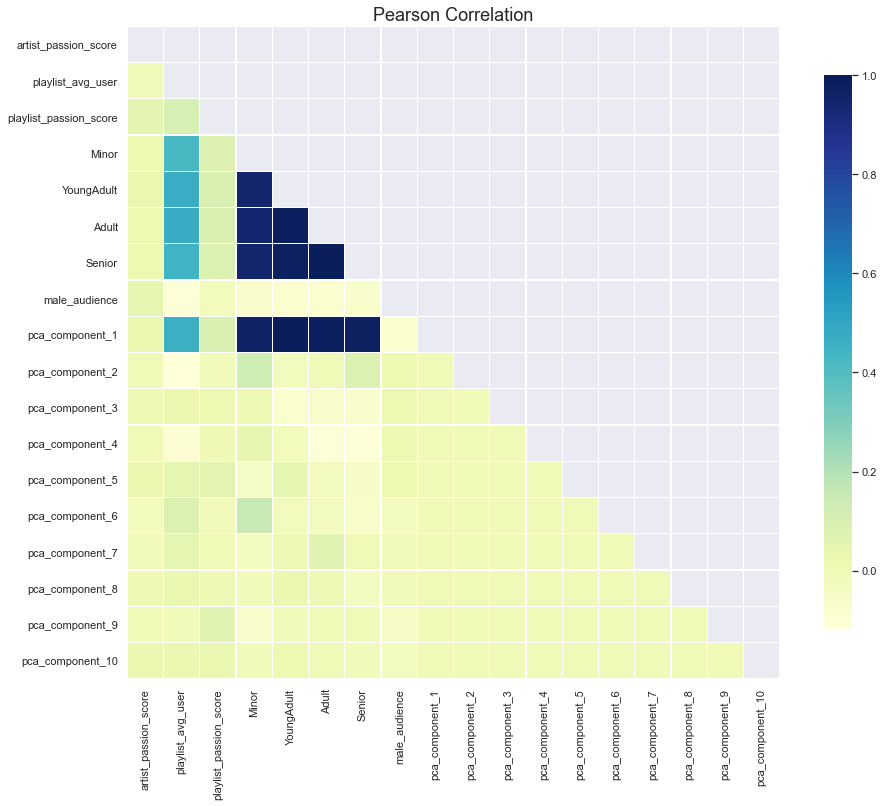

In [86]:
# Pearson Correlation, without multicollinearity 
mask = np.zeros_like(x_train_final.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation',fontsize=18)

cmap = "YlGnBu"

sns.heatmap(x_train_final.corr(),linewidths=0.30,vmax=1.00,square=True,linecolor='w',cmap = cmap, 
            mask=mask,cbar_kws={"shrink": 0.85})
plt.show();

In [87]:
# transformation and pre-processing of test set

In [88]:
# Creating a copy of the X Test Dataframe
x_test = X_test_merged.copy() 

In [89]:
# pca columns
pca = ["pca_component_1", "pca_component_2", "pca_component_3", "pca_component_4", 
       "pca_component_5", "pca_component_6", "pca_component_7", "pca_component_8", 
       "pca_component_9", "pca_component_10"]
x_test_pca = x_test[pca]

In [90]:
# artist column
x_test_artist = x_test["artist_name"]

In [91]:
# select variables to standardize 
x_test_features = x_test.drop(["artist_name", "pca_component_1", "pca_component_2", 
                               "pca_component_3", "pca_component_4", "pca_component_5", 
                               "pca_component_6", "pca_component_7", "pca_component_8", 
                               "pca_component_9", "pca_component_10"], axis = 1)

In [92]:
# scale remaining features 
scaler = preprocessing.StandardScaler().fit(x_test_features)
x_test_features_scaled = scaler.transform(x_test_features)

In [93]:
# Creating dataframe with scaled features
x_test_scaled = pd.DataFrame(x_test_features_scaled, index=x_test_features.index, columns=x_test_features.columns)
x_test_scaled

,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances
56,-0.218290,-0.217904,-0.173909,-0.455539,-0.457202,NaN,-0.151457,-0.211563,-0.229831,-0.217051,0.263465,-0.224292
106,-0.215244,-0.214548,-0.148422,0.488827,0.464588,-0.349166,-0.151457,-0.207100,-0.227721,-0.217051,1.102540,-0.224292
154,-0.155895,-0.168254,0.163696,-0.414480,-0.417124,-0.349166,-0.151457,-0.205203,-0.200291,0.156864,0.928416,-0.224292
641,-0.213599,-0.213429,-0.042668,-0.398056,-0.401093,-0.349166,-0.151457,-0.205538,-0.227721,-0.216347,0.447172,-0.224292
643,-0.218900,-0.218744,1.380797,-0.455539,-0.457202,NaN,-0.151457,-0.212009,-0.231677,-0.217756,1.749826,-0.224292
...,...,...,...,...,...,...,...,...,...,...,...,...
448,-0.202326,-0.199863,-0.162435,0.276686,0.264199,-0.231975,-0.138959,-0.190921,-0.215061,-0.206489,-0.447167,-0.224292
81,-0.164547,-0.174478,0.146105,-0.150527,-0.128945,0.936935,-0.101464,-0.172956,-0.182356,-0.159309,0.382040,-0.224292
100,-0.218900,-0.218604,-0.173909,-0.455539,-0.457202,NaN,-0.151457,-0.211786,-0.231413,-0.218460,1.749826,-0.224292
59,-0.151264,-0.159653,0.071426,-0.193786,-0.201705,-0.349166,-0.145208,-0.177977,-0.115627,-0.152267,0.847536,-0.224292


In [94]:
# Adding scaled X Test feature columns to X Test Artists in Dataframe
x_test_scaled = pd.concat([x_test_artist, x_test_scaled.set_index(x_test_artist.index)], axis=1)
x_test_scaled = pd.concat([x_test_scaled, x_test_pca.set_index(x_test_scaled.index)], axis=1)
x_test_scaled

,artist_name,artist_stream_count,artist_num_users,artist_passion_score,playlist_avg_user,playlist_avg_stream,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,top_10_appearances,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10
56,BSSMNT,-0.218290,-0.217904,-0.173909,-0.455539,-0.457202,NaN,-0.151457,-0.211563,-0.229831,-0.217051,0.263465,-0.224292,0.745100,0.170965,-0.163003,-0.119999,0.088395,-0.227725,0.158937,0.138807,0.025122,0.271691
106,Chevy Woods,-0.215244,-0.214548,-0.148422,0.488827,0.464588,-0.349166,-0.151457,-0.207100,-0.227721,-0.217051,1.102540,-0.224292,3.619188,0.191931,-0.167464,-0.267803,0.861671,-0.800570,0.013591,0.497653,-0.224271,1.215666
154,Dexys,-0.155895,-0.168254,0.163696,-0.414480,-0.417124,-0.349166,-0.151457,-0.205203,-0.200291,0.156864,0.928416,-0.224292,60.016396,1.996709,-14.296611,-13.402828,9.586285,-18.292463,2.030231,4.513182,-1.351196,11.498669
641,Yasutaka Nakata,-0.213599,-0.213429,-0.042668,-0.398056,-0.401093,-0.349166,-0.151457,-0.205538,-0.227721,-0.216347,0.447172,-0.224292,5.174345,0.198970,-0.316552,-0.645882,0.720597,-0.836292,0.460084,0.577238,-0.338346,1.302662
643,Ylric Illians,-0.218900,-0.218744,1.380797,-0.455539,-0.457202,NaN,-0.151457,-0.212009,-0.231677,-0.217756,1.749826,-0.224292,0.175690,-0.004588,-0.011470,-0.011590,0.056601,-0.045784,-0.054137,0.003529,-0.027790,0.030858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,Pink Slip,-0.202326,-0.199863,-0.162435,0.276686,0.264199,-0.231975,-0.138959,-0.190921,-0.215061,-0.206489,-0.447167,-0.224292,15.828635,1.240706,-2.677920,-2.697401,2.459757,-4.071149,0.869574,1.607935,-0.296402,3.970964
81,Boef,-0.164547,-0.174478,0.146105,-0.150527,-0.128945,0.936935,-0.101464,-0.172956,-0.182356,-0.159309,0.382040,-0.224292,50.597740,4.408428,0.162788,-2.851895,9.793491,-8.246785,3.280725,6.614345,-3.195006,16.420097
100,Chad,-0.218900,-0.218604,-0.173909,-0.455539,-0.457202,NaN,-0.151457,-0.211786,-0.231413,-0.218460,1.749826,-0.224292,0.171988,-0.010729,0.029196,0.001443,0.046051,-0.014751,-0.002269,0.017285,-0.019779,0.028968
59,Banks & Steelz,-0.151264,-0.159653,0.071426,-0.193786,-0.201705,-0.349166,-0.145208,-0.177977,-0.115627,-0.152267,0.847536,-0.224292,64.122200,4.626585,-12.219607,-12.444792,9.744295,-17.635674,5.489061,6.547477,-1.761263,15.014666


In [95]:
# Check for missing values
x_test_scaled.count(0)/x_test_scaled.shape[0] * 100

artist_name               100.000000
artist_stream_count       100.000000
artist_num_users          100.000000
artist_passion_score      100.000000
playlist_avg_user         100.000000
playlist_avg_stream       100.000000
playlist_passion_score     66.331658
Minor                     100.000000
YoungAdult                100.000000
Adult                     100.000000
Senior                    100.000000
male_audience             100.000000
top_10_appearances        100.000000
pca_component_1           100.000000
pca_component_2           100.000000
pca_component_3           100.000000
pca_component_4           100.000000
pca_component_5           100.000000
pca_component_6           100.000000
pca_component_7           100.000000
pca_component_8           100.000000
pca_component_9           100.000000
pca_component_10          100.000000
dtype: float64

Missing values observed in columns "playlist_passion_score"

In [96]:
# Handle missing values

# Fill playlist passion score NA = 0 
x_test_scaled["playlist_passion_score"] = x_test_scaled["playlist_passion_score"].fillna(0)

In [97]:
# drop variables indicating multicollinearity
x_test_final = x_test_scaled.drop(["artist_stream_count", 
                                   "playlist_avg_stream", 
                                   "artist_num_users",
                                   "top_10_appearances"], axis = 1)

In [98]:
# final train set 
train_set = pd.concat([x_train_final, y_train], axis = 1)
train_set

,artist_name,artist_passion_score,playlist_avg_user,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10,success_binary
133,Daniella Mason,-0.173275,-0.462083,-0.368571,-0.151011,-0.177058,-0.172565,-0.163266,-0.788661,-2.992491,0.145448,-0.102796,-0.075100,-0.261500,-0.090708,-0.078492,-0.071781,-0.305747,-0.085636,0
126,Crying Day Care Choir,-0.262308,-0.334123,-0.368571,-0.151011,-0.180463,-0.175098,-0.163266,-0.597408,-3.004898,0.144743,-0.105028,-0.075653,-0.265168,-0.086917,-0.076404,-0.072939,-0.304837,-0.091842,0
639,YFN Lucci,-0.133130,0.094423,-0.154737,-0.073473,-0.127058,-0.141935,-0.143166,0.827923,-2.369132,0.135369,0.036813,0.101779,-0.037701,-0.008093,-0.128936,-0.200332,-0.108339,-0.193684,0
490,SWEAT,-0.000557,3.283631,1.629140,-0.151011,-0.140950,-0.070313,-0.072242,0.092273,-2.263916,0.416266,-0.195282,-0.216819,0.061541,0.061272,-0.041368,0.163179,-0.228759,0.068050,0
206,HEDIA,-0.188042,5.903662,-0.107530,-0.095011,-0.040464,0.022496,-0.001318,-0.017869,0.721657,-1.210932,-0.800722,1.889089,-1.241450,1.059177,3.138207,-0.412715,1.491993,3.392102,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,RIVRS,-0.125447,0.033468,-0.219896,-0.133780,-0.139599,-0.126275,-0.129958,-0.646558,-2.359498,0.047680,-0.177895,-0.185154,0.150280,0.617241,-0.002922,0.159434,-0.526652,-0.324826,0
76,Bl!ndman,-0.262308,-0.508613,0.000000,-0.151011,-0.181004,-0.176134,-0.164415,-0.343887,-3.019408,0.147580,-0.101181,-0.072484,-0.267208,-0.084740,-0.076726,-0.073369,-0.303837,-0.090968,0
362,Maria Peszek,-0.159217,-0.415552,-0.368571,-0.151011,-0.180517,-0.173486,-0.163266,-0.449521,-3.012279,0.146968,-0.101727,-0.074116,-0.266001,-0.085973,-0.077290,-0.072916,-0.304286,-0.090295,0
365,Marie Bothmer,-0.262308,-0.415552,-0.368571,-0.151011,-0.180680,-0.176364,-0.164415,-1.048113,-3.018585,0.147597,-0.101214,-0.072495,-0.266845,-0.085036,-0.076948,-0.073232,-0.303913,-0.090538,0


In [99]:
# final test set
test_set = pd.concat([x_test_final, y_test], axis = 1)
test_set

,artist_name,artist_passion_score,playlist_avg_user,playlist_passion_score,Minor,YoungAdult,Adult,Senior,male_audience,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,pca_component_8,pca_component_9,pca_component_10,success_binary
56,BSSMNT,-0.173909,-0.455539,0.000000,-0.151457,-0.211563,-0.229831,-0.217051,0.263465,0.745100,0.170965,-0.163003,-0.119999,0.088395,-0.227725,0.158937,0.138807,0.025122,0.271691,0
106,Chevy Woods,-0.148422,0.488827,-0.349166,-0.151457,-0.207100,-0.227721,-0.217051,1.102540,3.619188,0.191931,-0.167464,-0.267803,0.861671,-0.800570,0.013591,0.497653,-0.224271,1.215666,0
154,Dexys,0.163696,-0.414480,-0.349166,-0.151457,-0.205203,-0.200291,0.156864,0.928416,60.016396,1.996709,-14.296611,-13.402828,9.586285,-18.292463,2.030231,4.513182,-1.351196,11.498669,0
641,Yasutaka Nakata,-0.042668,-0.398056,-0.349166,-0.151457,-0.205538,-0.227721,-0.216347,0.447172,5.174345,0.198970,-0.316552,-0.645882,0.720597,-0.836292,0.460084,0.577238,-0.338346,1.302662,0
643,Ylric Illians,1.380797,-0.455539,0.000000,-0.151457,-0.212009,-0.231677,-0.217756,1.749826,0.175690,-0.004588,-0.011470,-0.011590,0.056601,-0.045784,-0.054137,0.003529,-0.027790,0.030858,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,Pink Slip,-0.162435,0.276686,-0.231975,-0.138959,-0.190921,-0.215061,-0.206489,-0.447167,15.828635,1.240706,-2.677920,-2.697401,2.459757,-4.071149,0.869574,1.607935,-0.296402,3.970964,0
81,Boef,0.146105,-0.150527,0.936935,-0.101464,-0.172956,-0.182356,-0.159309,0.382040,50.597740,4.408428,0.162788,-2.851895,9.793491,-8.246785,3.280725,6.614345,-3.195006,16.420097,0
100,Chad,-0.173909,-0.455539,0.000000,-0.151457,-0.211786,-0.231413,-0.218460,1.749826,0.171988,-0.010729,0.029196,0.001443,0.046051,-0.014751,-0.002269,0.017285,-0.019779,0.028968,0
59,Banks & Steelz,0.071426,-0.193786,-0.349166,-0.145208,-0.177977,-0.115627,-0.152267,0.847536,64.122200,4.626585,-12.219607,-12.444792,9.744295,-17.635674,5.489061,6.547477,-1.761263,15.014666,0


Finally, we want to take a look out the class balance in our dependent variable.

Given the natural bias in our data, i.e. there are more cases of failure than of success in the training and test sets; there is a strong bias toward predicting ‘failure’. Based on our complete (unbalanced classes) training sample, if the model only predicted ‘failure’, we would achieve an accuracy of 88.8%. 

To give us a more even class balance, without losing too much data, we will sample data from the bigger class to achive a class balance closer to 60-40. 

There is another way to determine the accuracy of our predictions using a confusion matrix and ROC curve, but more on that later. For now, we will go ahead with sampling the bigger class:

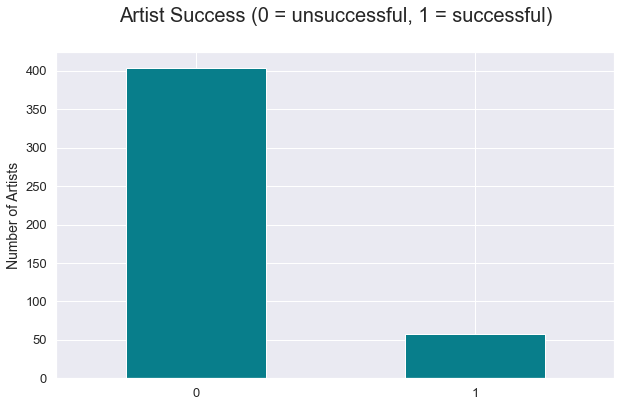

In [100]:
# Class balance
ax = train_set['success_binary'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Artist Success (0 = unsuccessful, 1 = successful)', size=20, pad=30)
ax.set_ylabel('Number of Artists', fontsize=14)

plt.xticks(rotation=0)
plt.show();

In [101]:
# utilize SMOTE to give a more even class balance 
!pip install imbalanced-learn
!pip install imblearn -U; 
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
!pip install delayed; # restart kernel after installing
# !conda install -c conda-forge imbalanced-learn
# !conda install nb_conda


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -;
ERROR: Invalid requirement: '#'


In [102]:
# describes info about train and test set 
print("Number X_train dataset: ", x_train_final.shape) 
print("Number  y_train dataset: ", y_train.shape) 

Number X_train dataset:  (462, 19)
Number  y_train dataset:  (462,)


In [103]:
#Hightlight Oversampling bias of uncessful artists
print("Before OverSampling, counts of label '1': {}".format(sum(train_set['success_binary'] == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_set['success_binary'] == 0))) 

Before OverSampling, counts of label '1': 58
Before OverSampling, counts of label '0': 404 



In [104]:
# Creating X and y datasets for SMOTE
X = train_set.drop(['success_binary','artist_name'], axis=1)
y = train_set['success_binary']

#implement SMOTE
sm = SMOTE(random_state = 2) 
X_sm, y_sm = sm.fit_resample(X, y) 

print("After OverSampling, counts of label '1': {}".format(sum(y_sm == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_sm == 0))) 

After OverSampling, counts of label '1': 404
After OverSampling, counts of label '0': 404


For reference - our training data is now equal in successful and unsucessful artists. Train set is under variables X_sm and y_sm

## 4.	Evaluate algorithms 

**Model Selection**

There are number of classification models available to us via the **`scikit-learn`** package, and we can rapidly experiment using each of them to find the optimal model.

Below is an outline of the steps we will take to arrive at the best model:

*	Split data into training and validation (hold-out) set
*	Use cross-validation to fit different models to training set
*	Select model with the highest cross-validation score as model of choice
*	Tune hyper parameters of chosen model.
*	Test the model on hold-out set


In [105]:
# Removing artist name from set as this is not relevant to predicting success
val_test_set = test_set.drop(['artist_name'], axis=1)

# Removing success binary as this labels should not be in x values
X_val_test = val_test_set.drop(['success_binary'], axis=1)

# Renaming Y val test to avoid clashing with previously named variables
y_val_test = y_test



In [106]:
# Splitting validation and test sets based of the original test set 
# The SMOTE datasets (X_sm and y_sm) will be used to train the models
X_val, X_test, y_val, y_test_final = train_test_split(X_val_test, y_val_test, 
                                                test_size=0.5, random_state=42)

### Support Vector Machine

#### Baseline Model

In [107]:
# Setting up Base Support Vector Machine Classifier Model
SVM = SVC(gamma='auto', random_state=42)

# Fitting Support Vector Machine Classifier Model
SVM = SVM.fit(X_sm, y_sm)

In [108]:
# Predicting Values with the validation set
y_pred_SVM_val = SVM.predict(X_val)

# Accuracy score for Base SVC
SVM_base_accuracy = accuracy_score(y_val, y_pred_SVM_val)
print('The Base SVM classifier has an accuracy score of {:0.2f}%.'.format(100*SVM_base_accuracy))

# F1 score for Base SVC 
SVM_base_f1_score = f1_score(y_val,y_pred_SVM_val,average='macro')
print('The Base SVM classifier has an f1-score of {:0.2f}%.'.format(100*SVM_base_f1_score))

The Base SVM classifier has an accuracy score of 12.12%.
The Base SVM classifier has an f1-score of 10.81%.


#### Tuned Model with Grid Search

In [109]:
#Define parameter grid
param_grid_SVM = {'C':[0.1,1,10,100],
                  'gamma':[1,0.1,0.01,0.001],
                  'kernel':['rbf','poly','sigmoid']}

# Setting the Grid Search with 3 fold cross Validation
grid_search_SVM = GridSearchCV(estimator = SVM,
                               param_grid = param_grid_SVM,
                               n_jobs = 4,
                               cv=3, 
                               refit = True)

# Fitting Grid Search
grid_search_SVM.fit(X_sm, y_sm)

# Viewing the Best Parameters of the Grid Search
grid_search_SVM.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'poly'}

In [110]:
#Fitting tuned SVM Classifier 
SVM2 = grid_search_SVM.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_SVM_val_2 = SVM2.predict(X_val)

# Accuracy score for the Tuned SVC
SVM_grid_accuracy= accuracy_score(y_val, y_pred_SVM_val_2)
print('The tuned SVM classifier has an accuracy score of {:0.2f}%.'.format(100*SVM_grid_accuracy))
print('The hypertuning has induced an improvement of {:0.2f}% in the model accuracy score.'.format( 100 * (SVM_grid_accuracy - SVM_base_accuracy) / SVM_base_accuracy))

# F! score for the Tuned SVC
SVM_grid_f1_score = f1_score(y_val, y_pred_SVM_val_2, average='macro')
print('The tuned SVM classifier has an f1 score of {:0.2f}%.'.format(100*SVM_grid_f1_score))
print('The hypertuning has induced an improvement of {:0.2f}% in the model f1 score'.format( 100 * (SVM_grid_f1_score - SVM_base_f1_score) / SVM_base_f1_score))

The tuned SVM classifier has an accuracy score of 15.15%.
The hypertuning has induced an improvement of 25.00% in the model accuracy score.
The tuned SVM classifier has an f1 score of 14.44%.
The hypertuning has induced an improvement of 33.61% in the model f1 score


### Linear Discriminant Analysis

#### Baseline Model

In [111]:
# Setting up Base Linear Discriminant Analysis Classifier Model
lda = LinearDiscriminantAnalysis()

# Fitting Linear Discriminant Analysis Classifier Model
lda = lda.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_lda = lda.predict(X_val)

# Assigning observations to groups
print(np.unique(y_pred_lda, return_counts=True))

(array([0, 1]), array([54, 45], dtype=int64))


Model assigned 54 observations to unsuccessful group and 45 observations to the successful group.

In [112]:
# Printing Confusion Matrix
print(confusion_matrix(y_pred_lda, y_val))

[[54  0]
 [33 12]]


In [113]:
# Printing Classification Report
print(classification_report(y_val, y_pred_lda, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.621     0.766        87
           1      0.267     1.000     0.421        12

    accuracy                          0.667        99
   macro avg      0.633     0.810     0.594        99
weighted avg      0.911     0.667     0.724        99



#### Tuned Model with Grid Search

In [114]:
# parameter tuning
lda1 = LinearDiscriminantAnalysis(shrinkage='auto')

# Search grid for optimal parameters
parameters_1 = {
    'solver': ('lsqr','eigen'),  #note svd does not run with shrinkage and models using it will be tuned separately
    'n_components': (1,5,1),
                   }

# Setting the Grid Search with 3 fold cross Validation
gs_lda = GridSearchCV(estimator = lda1,
                      param_grid = parameters_1,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      cv = 3)

# Fitting Grid Search
gs_lda.fit(X_sm, y_sm)

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.78342283 0.78342283        nan        nan 0.78342283 0.78342283]
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearDiscriminantAnalysis(shrinkage='auto'),
             n_jobs=-1,
             param_grid={'n_components': (1, 5, 1),
                         'solver': ('lsqr', 'eigen')},
             scoring='accuracy')

In [115]:
# Printing best parameters and score based on Grid Search
print(gs_lda.best_params_)
print(gs_lda.best_score_) 

{'n_components': 1, 'solver': 'lsqr'}
0.7834228280324934


In [116]:
#Fitting tuned LDA Classifier Model
lda2 = gs_lda.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_lda2 = lda2.predict(X_val)

# Printing Classification Report
print(classification_report(y_val, y_pred_lda2, digits=3))

              precision    recall  f1-score   support

           0      0.986     0.816     0.893        87
           1      0.407     0.917     0.564        12

    accuracy                          0.828        99
   macro avg      0.697     0.866     0.729        99
weighted avg      0.916     0.828     0.853        99



### Decision Tree

#### Baseline Model

In [117]:
# Setting up Base Decision Tree Classifier 
dt_clf = DecisionTreeClassifier(random_state=42)

# Fitting Decision Tree Classifier Model
dt_clf = dt_clf.fit(X_sm, y_sm)

In [118]:
# Predicting Values with the validation set
y_pred_dt_val = dt_clf.predict(X_val)

# Accuracy score for Base Decision Tree Classifier
dt_base_accuracy = accuracy_score(y_val, y_pred_dt_val)
print('The Base Decision Tree classifier has an accuracy score of {:0.2f}%.'.format(100*dt_base_accuracy))

# F1 score for Base Decision Tree Classifier
dt_base_f1_score = f1_score(y_val,y_pred_dt_val,average='macro')
print('The Base Decision Tree classifier has an f1-score of {:0.2f}%.'.format(100*dt_base_f1_score))

The Base Decision Tree classifier has an accuracy score of 60.61%.
The Base Decision Tree classifier has an f1-score of 45.60%.


#### Tuned Model with Grid Search

In [119]:
# Inputting range for each parameter based on best parameters of random search
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt"],
    "max_depth": [10, 12, 14, 16, 18, 20, 22, 24],
    "min_samples_leaf": [2, 4, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [5, 10, 15, 20, 25, 30, 35, 40],
}

# Starting the grid search models
grid_dt = GridSearchCV(estimator = dt_clf, param_grid = param_grid,
                       cv = 3, n_jobs = -1, verbose = 2)

# Fitting the grid search models
grid_dt.fit(X_sm, y_sm)

# Viewing the Best Parameters
pprint(grid_dt.best_params_)

Fitting 3 folds for each of 2048 candidates, totalling 6144 fits
{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 15}


In [120]:
#Fitting tuned SVM Classifier 
dt_clf2 = grid_dt.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_dt_val_2 = dt_clf2.predict(X_val)

# Accuracy score for the Tuned SVC
dt_grid_accuracy = accuracy_score(y_val, y_pred_dt_val_2)
print('The tuned Decision Tree classifier has an accuracy score of {:0.2f}%.'.format(100*dt_grid_accuracy))
print('The hypertuning has induced an improvement of {:0.2f}% in the model accuracy score.'.format( 100 * (dt_grid_accuracy - dt_base_accuracy) / dt_base_accuracy))

# F! score for the Tuned SVC
dt_grid_f1_score = f1_score(y_val, y_pred_dt_val_2, average='macro')
print('The tuned Decision Tree classifier has an f1 score of {:0.2f}%.'.format(100*dt_grid_f1_score))
print('The hypertuning has induced an improvement of {:0.2f}% in the model f1 score.'.format( 100 * (dt_grid_f1_score - dt_base_f1_score) / dt_base_f1_score))

The tuned Decision Tree classifier has an accuracy score of 64.65%.
The hypertuning has induced an improvement of 6.67% in the model accuracy score.
The tuned Decision Tree classifier has an f1 score of 56.89%.
The hypertuning has induced an improvement of 24.76% in the model f1 score.


### Random Forest

#### Baseline Model

In [121]:
# Setting up Base Random Forest Classifier 
rf_clf = RandomForestClassifier(random_state=42)

# Fitting Random Forest Classifier Model
rf_clf = rf_clf.fit(X_sm, y_sm)

In [122]:
# Predicting Values with the validation set
y_pred_rf_val = rf_clf.predict(X_val)

# Accuracy score for Base Random Forest Classifier
rf_base_accuracy = accuracy_score(y_val, y_pred_rf_val)
print('The Base Random Forest classifier has an accuracy score of {:0.2f}%.'.format(100*rf_base_accuracy))

# F1 score for Base Random Forest Classifier
rf_base_f1_score = f1_score(y_val,y_pred_rf_val, average='macro')
print('The Base Random Forest classifier has an f1-score of {:0.2f}%.'.format(100*rf_base_f1_score))

The Base Random Forest classifier has an accuracy score of 90.91%.
The Base Random Forest classifier has an f1-score of 79.40%.


#### Tuned Model with Grid Search

In [123]:
#Define parameter grid
param_grid_rf = {'bootstrap': [True],
                 'criterion': ['gini', "entropy"],
                 'max_depth': [None, 10, 15, 20],
                 'max_features': ['auto', "sqrt"],
                 'min_samples_leaf': [1, 2, 4, 8, 12],
                 'min_samples_split': [2, 5, 10, 15],
                 'n_estimators': [100, 120, 150]}

# Setting the Grid Search with 3 fold cross Validation
grid_search_rf = GridSearchCV(estimator = rf_clf,
                               param_grid = param_grid_rf,
                               n_jobs = 4,
                               cv=3, 
                               refit = True)

# Fitting Grid Search
grid_search_rf.fit(X_sm, y_sm)

# Viewing the Best Parameters of the Grid Search
grid_search_rf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 120}

In [124]:
#Fitting tuned SVM Classifier 
rf_clf2 = grid_search_rf.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_rf_val_2 = rf_clf2.predict(X_val)

# Accuracy score for the Tuned SVC
rf_grid_accuracy= accuracy_score(y_val, y_pred_rf_val_2)
print('The tuned Random Forest classifier has an accuracy score of {:0.2f}%.'.format(100*rf_grid_accuracy))
print('The hypertuning has induced an improvement of {:0.2f}% in the model accuracy score.'.format( 100 * (rf_grid_accuracy - rf_base_accuracy) / rf_base_accuracy))

# F! score for the Tuned SVC
rf_grid_f1_score = f1_score(y_val, y_pred_rf_val_2, average='macro')
print('The tuned Random Forest classifier has an f1 score of {:0.2f}%.'.format(100*rf_grid_f1_score))
print('The hypertuning has induced an improvement of {:0.2f}% in the model f1 score'.format( 100 * (rf_grid_f1_score - rf_base_f1_score) / rf_base_f1_score))

The tuned Random Forest classifier has an accuracy score of 91.92%.
The hypertuning has induced an improvement of 1.11% in the model accuracy score.
The tuned Random Forest classifier has an f1 score of 82.29%.
The hypertuning has induced an improvement of 3.64% in the model f1 score


### Gradient Boosting

#### Baseline Model

In [125]:
# Setting up Base Gradient Boosting Classifier 
gb_clf = GradientBoostingClassifier(random_state = 42)

# Fitting Base Gradient Boosting Classifier Model
gb_clf = gb_clf.fit(X_sm, y_sm)

In [126]:
# Predicting Values with the validation set
y_pred_gb_val = gb_clf.predict(X_val)

# Accuracy score for Base Gradient Boosting Classifier
gb_base_accuracy = accuracy_score(y_val, y_pred_gb_val)
print('The Base Gradient Boosting classifier has an accuracy score of {:0.2f}%.'.format(100*gb_base_accuracy))

# F1 score for Base Gradient Boosting Classifier
gb_base_f1_score = f1_score(y_val, y_pred_gb_val, average='macro')
print('The Base Gradient Boosting classifier has an f1-score of {:0.2f}%.'.format(100*gb_base_f1_score))

The Base Gradient Boosting classifier has an accuracy score of 81.82%.
The Base Gradient Boosting classifier has an f1-score of 70.69%.


#### Randomised Search for Grid Search Parameters

In [127]:
# Setting the loss function to be optimised
loss = ["deviance", "exponential"]

# Seting the learning rate to be used
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

# Setting the number of boosting stages
n_estimators = [int(i) for i in np.linspace(start = 100, stop = 500, num = 5)]

# Setting the number of features to consider when searching for the best split
max_features = ['auto', 'sqrt']

# Setting the maximum number of levels of regression estimators
max_depth = [5, 10, 15, 20]

# Setting the minimum number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# Setting the minimum number of samples required to be a leaf node
min_samples_leaf = [1, 2, 4]

# Inputting range for each parameter into the random grid search
rand_grid = {'loss': loss,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

# Viewing random grid search parameters
pprint(rand_grid)

{'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
 'loss': ['deviance', 'exponential'],
 'max_depth': [5, 10, 15, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [128]:
# Randomly searching parameters, with 3-fold cross validation, across 1000 combinations
rand_gb = RandomizedSearchCV(estimator = gb_clf, param_distributions = rand_grid, n_iter = 1000, 
                             cv = 3, verbose=2, random_state = 42, n_jobs = -1)

# Fitting the random search models
rand_gb.fit(X_sm, y_sm)

# Vieweing the Best Parameters
pprint(rand_gb.best_params_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
{'learning_rate': 0.3,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}


#### Tuned Model with Grid Search

In [129]:
#Define parameter grid
param_grid_gb = {"learning_rate": [0.25, 0.3, 0.3],
              "loss" : ["deviance"],
              "max_depth": [3, 5, 10],
              "max_features": ["sqrt"],
              "min_samples_leaf": [1, 2],
              "min_samples_split": [2, 3],
              "n_estimators": [200, 400, 600]}


# Setting the Grid Search with 3 fold cross Validation
grid_search_gb = GridSearchCV(estimator = gb_clf, param_grid = param_grid_gb,
                              cv = 3, n_jobs = -1, verbose = 2)

# Fitting Grid Search
grid_search_gb.fit(X_sm, y_sm)

# Viewing the Best Parameters of the Grid Search
grid_search_gb.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'learning_rate': 0.3,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [130]:
#Fitting tuned Gradient Boosting Classifier 
gb_clf2 = grid_search_gb.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_gb_val_2 = gb_clf2.predict(X_val)

# Accuracy score for the Tuned Gradient Boosting
gb_grid_accuracy= accuracy_score(y_val, y_pred_gb_val_2)
print('The tuned Gradient Boosting classifier has an accuracy score of {:0.2f}%.'.format(100*gb_grid_accuracy))
print('The hypertuning has induced an improvement of {:0.2f}% in the model accuracy score.'.format( 100 * (gb_grid_accuracy - gb_base_accuracy) / gb_base_accuracy))

# F! score for the Tuned Gradient Boosting
gb_grid_f1_score = f1_score(y_val, y_pred_rf_val_2, average='macro')
print('The tuned Gradient Boosting classifier has an f1 score of {:0.2f}%.'.format(100*gb_grid_f1_score))
print('The hypertuning has induced an improvement of {:0.2f}% in the model f1 score'.format( 100 * (gb_grid_f1_score - gb_base_f1_score) / gb_base_f1_score))

The tuned Gradient Boosting classifier has an accuracy score of 90.91%.
The hypertuning has induced an improvement of 11.11% in the model accuracy score.
The tuned Gradient Boosting classifier has an f1 score of 82.29%.
The hypertuning has induced an improvement of 16.41% in the model f1 score


### XGBoost

#### Baseline Model

In [131]:
# Setting up Base XGBoost Classifier 
xgb_clf = xgb.XGBClassifier(random_state = 42)

# Fitting Base XGBoost Model
xgb_clf = xgb_clf.fit(X_sm, y_sm)

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [132]:
# Predicting Values with the validation set
y_pred_xgb_val = xgb_clf.predict(X_val)

# Accuracy score for Base Random Forest Classifier
xgb_base_accuracy = accuracy_score(y_val, y_pred_xgb_val)
print('The Base XGBoost classifier has an accuracy score of {:0.2f}%.'.format(100*xgb_base_accuracy))

# F1 score for Base Random Forest Classifier
xgb_base_f1_score = f1_score(y_val, y_pred_xgb_val, average='macro')
print('The Base XGBoost classifier has an f1-score of {:0.2f}%.'.format(100*xgb_base_f1_score))

The Base XGBoost classifier has an accuracy score of 79.80%.
The Base XGBoost classifier has an f1-score of 70.78%.


#### Randomised Search for Grid Search Parameters

In [133]:
# Setting the maximum number of levels of regression estimators
max_depth = [5, 10, 20, 25]

# Setting the loweset number of weigths of observations needed in a child
min_child_weight = [1, 2, 5]

# Seting the learning rate (eta) to be used
learning_rate = [0.01, 0.1, 0.2]

# Setting the fraction of random samples per tree
subsample = [0.5, 0.75, 1]

# Setting the ratio of columns to sample from with each tree
colsample_bytree = [0.25, 0.5, 1]

# Setting the minimum decrease in loss for a node to split
gamma = [0.5, 1, 2]

# Setting the number of boosting stages
n_estimators = [int(i) for i in np.linspace(start = 100, stop = 500, num = 5)]

# Inputting range for each parameter into the random grid search
rand_grid = {'max_depth': max_depth,
             'min_child_weight': min_child_weight,
             'learning_rate': learning_rate,
             'subsample': subsample,
             'colsample_bytree': colsample_bytree,
             'gamma': gamma,
             'n_estimators': n_estimators
}

# Viewing random grid search parameters
pprint(rand_grid)

{'colsample_bytree': [0.25, 0.5, 1],
 'gamma': [0.5, 1, 2],
 'learning_rate': [0.01, 0.1, 0.2],
 'max_depth': [5, 10, 20, 25],
 'min_child_weight': [1, 2, 5],
 'n_estimators': [100, 200, 300, 400, 500],
 'subsample': [0.5, 0.75, 1]}


In [134]:
# Randomly searching parameters, with 3-fold cross validation, across 1000 combinations
rand_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = rand_grid, n_iter = 1000, 
                             cv = 3, verbose=2, random_state = 42, n_jobs = -1)

# Fitting the random search models
rand_xgb.fit(X_sm, y_sm)

# Vieweing the Best Parameters
pprint(rand_xgb.best_params_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 1,
 'n_estimators': 400,
 'subsample': 1}


#### Tuned Model with Grid Search

In [135]:
#Define parameter grid
param_grid_xgb = {'max_depth': [10, 15, 20],
                  'min_child_weight': [1, 2],
                  'learning_rate': [0.01, 0.1, 0.2],
                  'subsample': [0.5, 0.75, 1],
                  'colsample_bytree': [0.25, 0.5, 0.75],
                  'gamma': [0.5, 1],
                  'n_estimators': [200, 400, 800]}


# Setting the Grid Search with 3 fold cross Validation
grid_search_xgb = GridSearchCV(estimator = xgb_clf, param_grid = param_grid_xgb,
                               cv = 3, n_jobs = -1, verbose = 2)

# Fitting Grid Search
grid_search_xgb.fit(X_sm, y_sm)

# Viewing the Best Parameters of the Grid Search
grid_search_xgb.best_params_

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.25,
 'gamma': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 400,
 'subsample': 1}

In [136]:
#Fitting tuned Gradient Boosting Classifier 
xgb_clf2 = grid_search_xgb.best_estimator_.fit(X_sm, y_sm)

# Predicting Values with the validation set
y_pred_xgb_val_2 = xgb_clf2.predict(X_val)

# Accuracy score for the Tuned Gradient Boosting
xgb_grid_accuracy= accuracy_score(y_val, y_pred_xgb_val_2)
print('The tuned XGBoost classifier has an accuracy score of {:0.2f}%.'.format(100*xgb_grid_accuracy))
print('The hypertuning has induced an improvement of {:0.2f}% in the model accuracy score.'.format( 100 * (xgb_grid_accuracy - xgb_base_accuracy) / xgb_base_accuracy))

# F! score for the Tuned Gradient Boosting
xgb_grid_f1_score = f1_score(y_val, y_pred_rf_val_2, average='macro')
print('The tuned XGBoost classifier has an f1 score of {:0.2f}%.'.format(100*xgb_grid_f1_score))
print('The hypertuning has induced an improvement of {:0.2f}% in the model f1 score'.format( 100 * (xgb_grid_f1_score - xgb_base_f1_score) / xgb_base_f1_score))

[23:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The tuned XGBoost classifier has an accuracy score of 87.88%.
The hypertuning has induced an improvement of 10.13% in the model accuracy score.
The tuned XGBoost classifier has an f1 score of 82.29%.
The hypertuning has induced an improvement of 16.26% in the model f1 score


### Evaluate Classifiers

In [137]:
# List of Base classifiers
base_classifiers = [SVM, lda, dt_clf, rf_clf, gb_clf, xgb_clf] 

In [140]:
# Empty list for models accuracy and f1 scores
clf_base_accuracy = []
clf_base_f1_score = []

# Importing relevant packages
from sklearn.base import clone

# Setting number of cross validation folds to 3
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)

# For loop which appends cross validation (accuracy and f1) scores of base models to empty lists
for clf in base_classifiers:

    for (train_index, val_index), (train_index2, val_index2) in zip((skfolds.split(X_sm, y_sm)), (skfolds.split(X_val, y_val))):
        clone_clf = clone(clf)
        X_train_folds = X_sm.iloc[train_index]
        y_train_folds = (y_sm.iloc[train_index])
        X_val_fold = X_val.iloc[val_index2]
        y_val_fold = (y_val.iloc[val_index2])

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_val_fold)
        
        accuracy = accuracy_score(y_val_fold, y_pred)*100
        clf_base_accuracy.append(accuracy)
        
        f1 = f1_score(y_val_fold, y_pred, average='macro')*100
        clf_base_f1_score.append(f1)

[23:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jnlew\anaconda3\envs\Predictive A

In [141]:
# Reshaping scores array based on number of models and cross validation folds
clf_base_accuracy = np.reshape(clf_base_accuracy, (6, 3))
clf_base_f1_score = np.reshape(clf_base_f1_score, (6, 3))

# Calculating mean values for each model across their 3 folds
clf_base_mean_accuracy = clf_base_accuracy.mean(axis=1)
clf_base_mean_f1_score = clf_base_f1_score.mean(axis=1)

In [142]:
# Assigning each fine tuned model estimator to a variable
dt_clf2 = grid_dt.best_estimator_
rf_clf2 = grid_search_rf.best_estimator_
gb_clf2 = grid_search_gb.best_estimator_
xgb_clf2 = grid_search_xgb.best_estimator_

# List of Tuned classifiers
tuned_classifiers = [SVM2, lda2, dt_clf2, rf_clf2, gb_clf2, xgb_clf2]

In [143]:
# Empty list for models accuracy and f1 scores
clf_tuned_accuracy = []
clf_tuned_f1_score = []

# Setting number of cross validation folds to 3
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)

# For loop which appends cross validation (accuracy and f1) scores of tuned models to empty lists
for clf in tuned_classifiers:

    for (train_index, val_index), (train_index2, val_index2) in zip((skfolds.split(X_sm, y_sm)), (skfolds.split(X_val, y_val))):
        clone_clf = clone(clf)
        X_train_folds = X_sm.iloc[train_index]
        y_train_folds = (y_sm.iloc[train_index])
        X_val_fold = X_val.iloc[val_index2]
        y_val_fold = (y_val.iloc[val_index2])

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_val_fold)
        
        accuracy = accuracy_score(y_val_fold, y_pred)*100
        clf_tuned_accuracy.append(accuracy)
        
        f1 = f1_score(y_val_fold, y_pred, average='macro')*100
        clf_tuned_f1_score.append(f1)

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [144]:
# Reshaping scores array based on number of models and cross validation folds
clf_tuned_accuracy = np.reshape(clf_tuned_accuracy, (6, 3))
clf_tuned_f1_score = np.reshape(clf_tuned_f1_score, (6, 3))

# Calculating mean values for each model across their 3 folds
clf_tuned_mean_accuracy = clf_tuned_accuracy.mean(axis=1)
clf_tuned_mean_f1_score = clf_tuned_f1_score.mean(axis=1)

In [145]:
# List of the column and row names of model evaluation table
column_names = ["base_accuracy", "tuned_accuracy", "base_f1_score", "tuned_f1_score"]
row_names = ["SVC", "LDA", "Descision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]

# Concatenating, reshaping and transposing data for model evaluation table
eval_table_data = np.concatenate((clf_base_mean_accuracy, clf_tuned_mean_accuracy, clf_base_mean_f1_score, clf_tuned_mean_f1_score))
eval_table_data = np.reshape(eval_table_data, (4, 6))
eval_table_data = np.transpose(eval_table_data)

# Creating model evaluation table
eval_table = pd.DataFrame(data = eval_table_data, 
                          index = row_names,
                          columns = column_names)

eval_table

,base_accuracy,tuned_accuracy,base_f1_score,tuned_f1_score
SVC,12.121212,15.151515,10.810811,14.253776
LDA,64.646465,83.838384,57.989851,74.474959
Descision Tree,73.737374,83.838384,60.707368,76.612364
Random Forest,89.898990,90.909091,78.990205,80.869408
Gradient Boosting,80.808081,91.919192,70.776440,84.836270
XGBoost,82.828283,88.888889,72.959332,80.190396


### Voting ensemble 

In [149]:
# Empty List for accuracy and f1 score
vote_accuracy = []
vote_f1_score = []

# 3 fold cross validation being set up
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)


# Setting up voting classifier with equal weights
vote_clf = VotingClassifier(estimators=[('rf', rf_clf2),
                                        ('xgb', xgb_clf2),
                                        ('gb', gb_clf2)],
                            weights = None,
                            voting = "soft")

# For loop which appends cross validation (accuracy and f1) scores of tuned models to empty lists
for (train_index, val_index), (train_index2, val_index2) in zip((skfolds.split(X_sm, y_sm)), (skfolds.split(X_val, y_val))):
    clone_clf = clone(vote_clf)
    X_train_folds = X_sm.iloc[train_index]
    y_train_folds = (y_sm.iloc[train_index])
    X_val_fold = X_val.iloc[val_index2]
    y_val_fold = (y_val.iloc[val_index2])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_pred)*100
    vote_accuracy.append(accuracy)

    f1 = f1_score(y_val_fold, y_pred, average='macro')*100
    vote_f1_score.append(f1)

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [150]:
# Reshaping scores array based on number of models and cross validation folds
vote_accuracy = np.reshape(vote_accuracy, (1, 3))
vote_f1_score = np.reshape(vote_f1_score, (1, 3))

# Calculating mean values for each model across their 3 folds
vote_accuracy_mean = vote_accuracy.mean(axis=1)
vote_f1_score_mean = vote_f1_score.mean(axis=1)

In [151]:
# Creating Vote Evaluation Table
vote_eval_table = pd.DataFrame({'model_accuracy': vote_accuracy_mean,
                                'model_f1_score': vote_f1_score_mean})

# Renaming rows of table
vote_eval_table = vote_eval_table.rename(index={0: "Vote 1"})
vote_eval_table

,model_accuracy,model_f1_score
Vote 1,91.919192,84.83627



## 5. Present Results

Finally presenting our optimum result

In [152]:
# Setting up Final Voting Classifier Model
vote_clf = VotingClassifier(estimators=[('rf', rf_clf2),
                                        ('xgb', xgb_clf2),
                                        ('gb', gb_clf2)],
                            weights = None,
                            voting = "soft")

# Fitting Final Voting Classifier Model
vote_clf = vote_clf.fit(X_sm, y_sm)

# Predicting Values with the test set
y_pred_vot_test = vote_clf.predict(X_test)

# Accuracy score for Final Voting Classifier Model
fin_vot_accuracy = accuracy_score(y_test_final, y_pred_vot_test)
print('The Final Voting Classifier Model has an accuracy score of {:0.2f}%.'.format(100*fin_vot_accuracy))

# F1 score for Final Voting Classifier Model
fin_vot_f1_score = f1_score(y_test_final, y_pred_vot_test, average='macro')
print('The Final Voting Classifier Model has an f1-score of {:0.2f}%.'.format(100*fin_vot_f1_score))

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Final Voting Classifier Model has an accuracy score of 92.00%.
The Final Voting Classifier Model has an f1-score of 84.31%.


### Confusion Matrix

To get a better idea of the quality of our predictions, we can plot a confusion matrix and ROC curve. 


A confusion matrix is a technique for summarizing the performance of a classification algorithm that allows visualization of the performance of an algorithm. 

Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). 

The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

In [154]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(y_pred_vot_test, y_test_final)) 

[[81  2]
 [ 6 11]]


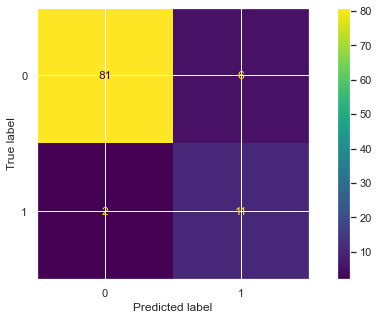

In [155]:
# Plot Confusion Matrix
plot_confusion_matrix(vote_clf, X_test, y_test_final)

### ROC Curve 

Receiver Operating Characteristic (ROC) curves show the ability of the model to classify subjects correctly across a range of decision thresholds, i.e. it plots the True Positive Rate vs. False Positive Rate at every probability threshold. 

The AUC summarizes the results of an ROC – it is the probability that a randomly chosen ‘success’ example has a higher probability of being a success than a randomly chosen ‘failure’ example. A random classification would yield an AUC of 0.5, and a perfectly accurate one would yield 1.


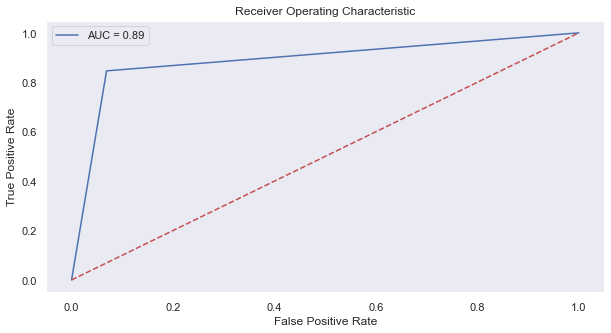

In [181]:
# Setting up ROC Curve
false_pos, true_pos, _ = roc_curve(y_test_final, y_pred_vot_test)

# Setting up AUC Score
auc = roc_auc_score(y_test_final, y_pred_vot_test)

# Plotting classifier ROC
plt.plot(false_pos, true_pos, label = 'AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r--')

# Adding the labels and titles to figure
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Now that you have a validated model, we can potentially analyze the features of the model, to understand which ones have had the most impact on predicting an artist’s success. 

To do this, we can plot the feature importance as determined by the classifier:

Text(0.5, 1.0, 'Random Forest - Feature Importance')

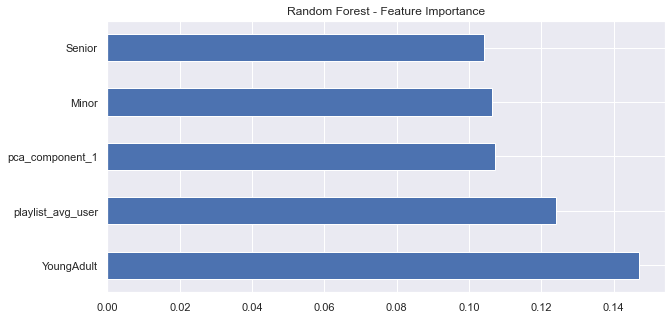

In [195]:
# Feature Importance - Random Forest
# Extracting the relevant model
rf_imp = vote_clf.named_estimators['rf']

# Fitting the relevant model
rf_imp.fit(X_sm, y_sm)

# Obtaining the score of the relevant model
rf_imp.score(X_test, y_test_final)

# Plotting the Top 5 features of the relevant model
(pd.Series(rf_imp.feature_importances_, index = X_sm.columns).nlargest(5).plot(kind = 'barh'))
plt.title('Random Forest - Feature Importance')

C:\Users\jnlew\anaconda3\envs\Predictive Analytics\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'XGBoost - Feature Importance')

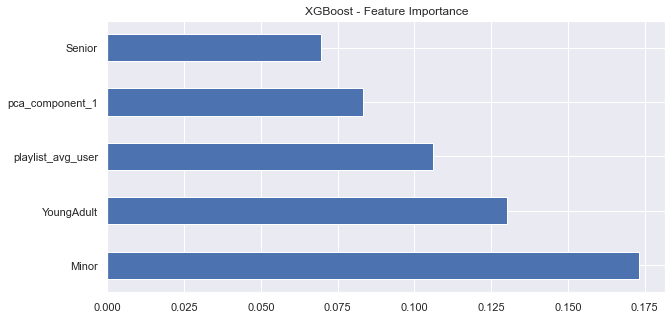

In [194]:
# Feature Importance - XGBoost
# Extracting the relevant model
xgb_imp = vote_clf.named_estimators['xgb']

# Fitting the relevant model
xgb_imp.fit(X_sm, y_sm)

# Obtaining the score of the relevant model
xgb_imp.score(X_test, y_test_final)

# Plotting the Top 5 features of the relevant model
(pd.Series(xgb_imp.feature_importances_, index = X_sm.columns).nlargest(5).plot(kind = 'barh'))
plt.title('XGBoost - Feature Importance')

Text(0.5, 1.0, 'Gradient Boosting - Feature Importance')

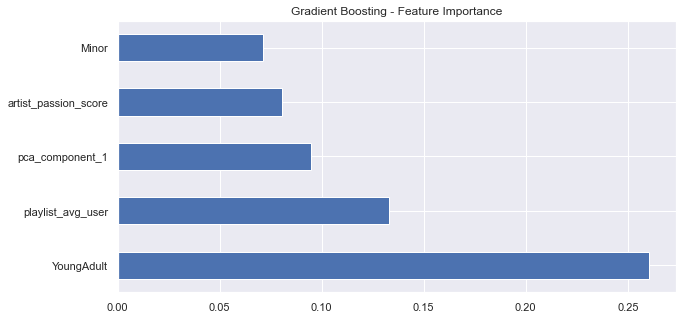

In [193]:
# Feature Importance - Gradient Boost
# Extracting the relevant model
gb_imp = vote_clf.named_estimators['gb']

# Fitting the relevant model
gb_imp.fit(X_sm, y_sm)

# Obtaining the score of the relevant model
gb_imp.score(X_test, y_test_final)

# Plotting the Top 5 features of the relevant model
(pd.Series(gb_imp.feature_importances_, index = X_sm.columns).nlargest(5).plot(kind = 'barh'))
plt.title('Gradient Boosting - Feature Importance')